In [1]:
#Conda env: py_3916

#Import packages
#---------------------------------------
import sys
from matplotlib import pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns

#Import your modules
#---------------------------------------
import plaque_f as pf
sys.path.insert(1, '/cndd3/dburrows/CODE/admin_tools/')
from admin_tools import admin_functions as adm

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'
s_fig = '/cndd3/dburrows/FIGS/'

%load_ext autoreload
sys.version

'3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) \n[GCC 9.4.0]'

# Load data

In [2]:
def run_(age, long_name, short_name):
    # Declare paths
    data_path = s_data + 'spatial_transcriptomics/plaques/coords/' + age + '/' + long_name + '.json'
    coord_path = '/cndd2/agelber/hal/qc_aligned/' + short_name + '/outs/spatial/tissue_positions.csv'
    genes_path = '/cndd2/agelber/hal/qc_aligned/' + short_name + '/outs/filtered_feature_bc_matrix.h5'
    meta = pd.read_csv('/home/AD/agelber/desp1/precast/prec_c25q25g3000/qc_cell_annotation.csv')
    meta_filt = meta[meta['sample'] == short_name]

    spot_df, gene_df = pf.sort_data(data_path, coord_path, genes_path, 
                                    meta_filt, min_cell_per_gene=0)#, norm_factor=1e6)
    
    #Sanity check
    assert spot_df.shape[0] == gene_df.shape[0] == meta_filt.shape[0]
    #assert 'Thy1' not in gene_df.columns.values or 'humanAPP' not in gene_df.columns.values
    print('Number of spots: ' + str(gene_df.shape[0]))
    print('Number of genes: ' + str(gene_df.shape[1]))
    return(spot_df, gene_df)

In [3]:
#Load in metadata
meta = pd.read_csv('/cndd2/agelber/hal/metadata.csv')
meta

,sample,age,sex,genotype,time,sample_number,sample_name,resequenced
0,039-A_S18,7 months,F,WT,ZT0,S18,039-A,False
1,039-B_S19,7 months,F,WT,ZT6,S19,039-B,True
2,039-C_S20,7 months,F,WT,ZT12,S20,039-C,True
3,039-D_S21,7 months,F,WT,ZT18,S21,039-D,False
4,042-A_S22,7 months,M,WT,ZT6,S22,042-A,False
...,...,...,...,...,...,...,...,...
61,351-D_S12,14 months,F,WT,ZT18,S12,351-D,False
62,043-A_S12,14 months,F,APP23,ZT0,S12,043-A,True
63,043-B_S13,14 months,M,APP23,ZT6,S13,043-B,True
64,043-C_S14,14 months,F,WT,ZT12,S14,043-C,True


In [16]:
#Load a dataset
#sort out names
age = 'old'
os.chdir('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/coords/' + age)
og = glob.glob('*.json')
ID = [i.split('.')[0] for i in og]
sub_ID=[]
for x,i in enumerate(og):
    if x != 1: sub_ID = np.append(sub_ID, i.split('_')[1][:-5])
    else: sub_ID = np.append(sub_ID, i[:-5])
x=0
spot_df, gene_df = run_('old',ID[x], sub_ID[x])



/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3397
Number of genes: 32284


In [17]:
spot_df

,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,plaque,cluster
111351,AAACAAGTATCTCCCA-1,1,50,102,413,1642,0,GP/TH
111352,AAACAATCTACTAGCA-1,1,3,43,1049,764,0,CA1
111353,AAACAGAGCGACTCCT-1,1,14,94,500,969,0,CA3-sp
111354,AAACAGTGTTCCTGGG-1,1,73,43,1046,2073,0,Cortex Layer 2/3
111355,AAACCCGAACGAAATC-1,1,45,115,273,1548,0,Amygdala
...,...,...,...,...,...,...,...,...
114743,TTGTTTCACATCCAGG-1,1,58,42,1057,1793,0,Cortex Layer 5b
114744,TTGTTTCATTAGTCTA-1,1,60,30,1186,1830,0,Cortex Layer 2/3
114745,TTGTTTCCATACAACT-1,1,45,27,1219,1550,0,Cortex Layer 4
114746,TTGTTTGTATTACACG-1,1,73,41,1067,2073,0,Cortex Layer 2/3


In [18]:
gene_df

,Xkr4,Gm1992,Gm19938,Gm37381,Rp1,Sox17,Gm37587,Gm37323,Mrpl15,Lypla1,...,Gm16367,AC163611.1,AC163611.2,AC140365.1,AC124606.2,AC124606.1,AC133095.2,AC133095.1,AC234645.1,AC149090.1
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
AAACAGTGTTCCTGGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
AAACCCGAACGAAATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
TTGTTTGTATTACACG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


# Visualise plaques



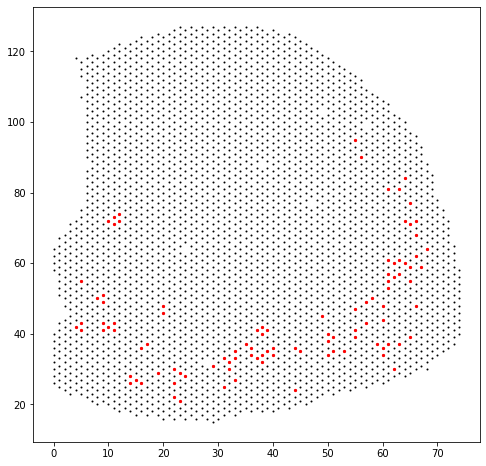

In [383]:
#PLOT PLAQUES
fig = plt.figure(figsize=(8,8))
xcoord, ycoord = spot_df['array_row'].values, spot_df['array_col'].values
plq_bool = spot_df['plaque'].values == 1

plt.scatter(xcoord, ycoord, s=1, c='k')
plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=5, c='red')
plt.show()

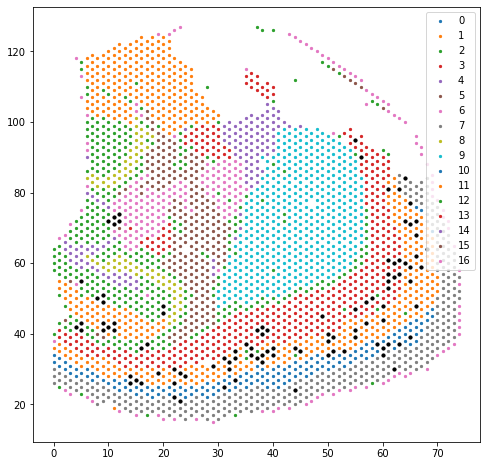

In [384]:

fig = plt.figure(figsize=(8,8))
clust_lab = spot_df['cluster'].values

for x in range(len(np.unique(clust_lab))): 
    plt.scatter(xcoord[np.where(clust_lab==x)[0]], ycoord[np.where(clust_lab==x)[0]], s=5, label = str(x))
plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
plt.legend()
#plt.savefig('fig_dump/plaque-clusters-01.svg', transparent=True)
plt.show()


In [390]:
clust_lab

array([17, 12,  2, ...,  7,  7,  2])

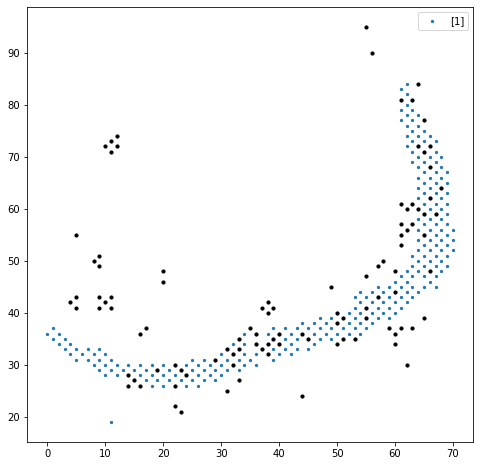

In [393]:
x=[1]
fig = plt.figure(figsize=(8,8))
plt.scatter(xcoord[np.where(clust_lab==x)[0]], ycoord[np.where(clust_lab==x)[0]], s=5, label = str(x))
plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
plt.legend()
#plt.savefig('fig_dump/plaque-clusters-01.svg', transparent=True)
plt.show()


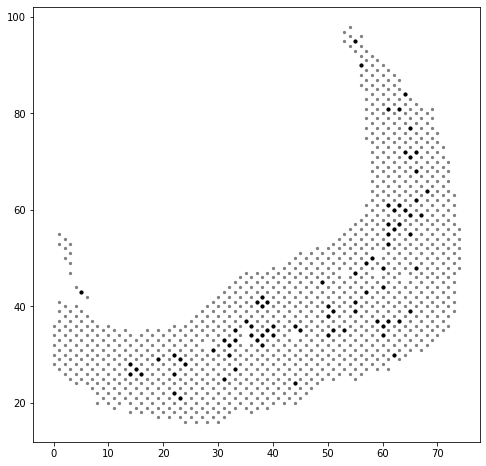

In [100]:
#Cortex plaques
cort_l = [3,6,8,9]

fig = plt.figure(figsize=(8,8))
for x in range(len(np.unique(clust_df['cluster']))): 
    if x in cort_l:
        plt.scatter(rows[row_ind[x]], cols[row_ind[x]], s=5, label = str(x), c = 'grey')
        plt.scatter(rows[np.intersect1d(np.where(plq_bool == True)[0], row_ind[x])], cols[np.intersect1d(np.where(plq_bool == True)[0], row_ind[x])], s=10, c='k')
#plt.savefig('fig_dump/plaque-clusters-cortex-01.svg', transparent=True)
plt.show()


# Plaque distribution 


In [29]:
#OLD ANIMALS
#sort out names
import glob
import os
age = 'old'
os.chdir('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/coords/' + age)
og = glob.glob('*.json')
ID = [i.split('.')[0] for i in og]
sub_ID=[]
for x,i in enumerate(og):
    if x != 1: sub_ID = np.append(sub_ID, i.split('_')[1][:-5])
    else: sub_ID = np.append(sub_ID, i[:-5])
ID, sub_ID



(['V11Y10_030-C',
  '030-B',
  'V11Y17_109-D',
  'V11Y17_109-A',
  'V10S15_040-C',
  'V11Y17_109-C',
  'S29_030-D',
  'V10S15_040-A',
  'V10S15_040-D'],
 array(['030-C', '030-B', '109-D', '109-A', '040-C', '109-C', '030-D',
        '040-A', '040-D'], dtype='<U32'))

In [30]:
#Define colormap by clusters
col_df = pd.read_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/metadata/colors.csv')
sort_clust = col_df['cluster_order'] #all clusters sorted 
sort_col = col_df['color']


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3285
Number of genes: 32284


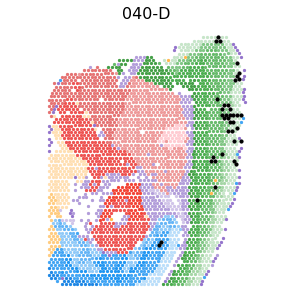

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3002
Number of genes: 32284


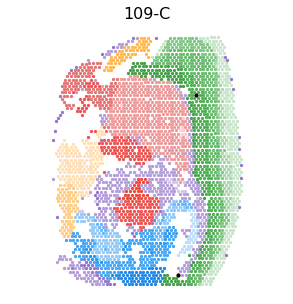

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2998
Number of genes: 32284


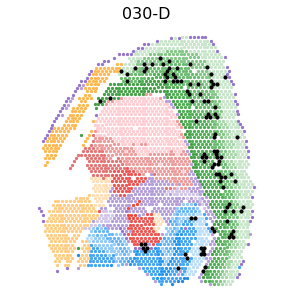

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3343
Number of genes: 32284


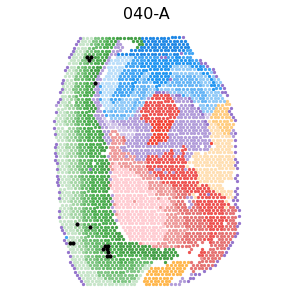

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3204
Number of genes: 32284


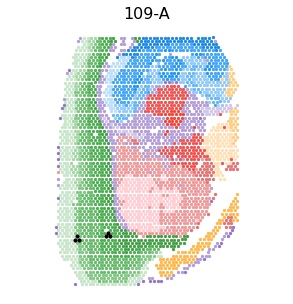

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3406
Number of genes: 32284


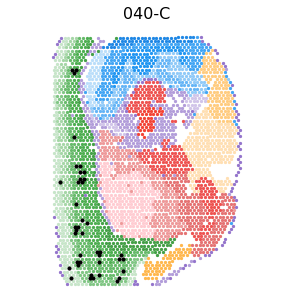

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2835
Number of genes: 32284


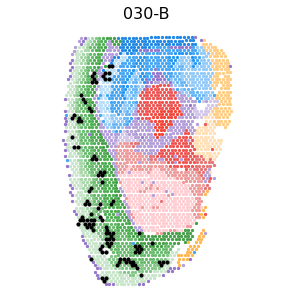

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3397
Number of genes: 32284


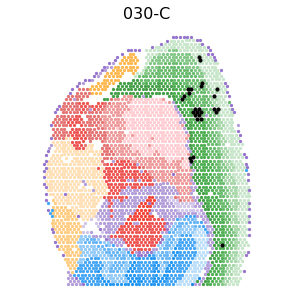

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2959
Number of genes: 32284


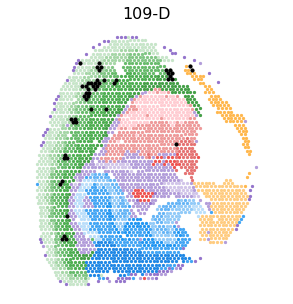

In [31]:

#plot and save all samples
for y,name in enumerate(sub_ID):
    spot_df, gene_df = run_(ID[y], sub_ID[y])
    clust_lab = spot_df['cluster'].values
    xcoord, ycoord = spot_df['pxl_row_in_fullres'].values, spot_df['pxl_col_in_fullres'].values
    plq_bool = spot_df['plaque'].values == 1


    fig,ax = plt.subplots(figsize=(5,5))
    for x in range(len(sort_clust)): 
        plt.scatter(xcoord[np.where(clust_lab==sort_clust[x])[0]], ycoord[np.where(clust_lab==sort_clust[x])[0]], s=5, label = sort_clust[x], color = sort_col[x], alpha=1)
    plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, markerscale=2)

    #remove all borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.axis('equal')
    plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    plt.title(sub_ID[y], fontsize=16)
    plt.savefig(s_fig + 'plaque-clusters-' + sub_ID[y] + '.svg', transparent=True)
    plt.show()



In [9]:
#Look at distribution of plaques across clusters
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()
for x,name in enumerate(sub_ID[:1]):
    spot_df, gene_df = run_('old',ID[x], sub_ID[x])
    cat_df = pd.concat([cat_df, spot_df])

clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']
# clust_df['region'] = cat_df.groupby('cluster').sum()['plaque'].index.values
clust_df['total spots'] = cat_df.groupby('cluster').count()['plaque']
clust_df['percent of spots'] = clust_df['plaque']/clust_df['total spots'] *100
clust_df['percent of spots'] = clust_df['percent of spots'].round(2)
clust_df['percent of all plaques'] = clust_df['plaque']/clust_df['plaque'].sum() *100
clust_df['percent of all plaques'] = clust_df['percent of all plaques'].round(2)

/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3397
Number of genes: 32284


In [10]:
clust_df

,plaque,total spots,percent of spots,percent of all plaques
cluster,,,,
Amygdala,0,146,0.00,0.00
CA1,0,65,0.00,0.00
CA3-so/sr,0,128,0.00,0.00
CA3-sp,0,70,0.00,0.00
COAa,0,279,0.00,0.00
COAp,0,110,0.00,0.00
"CTXsp (L6b, CLA, EP)",1,134,0.75,3.70
Caudoputamen,0,257,0.00,0.00
Cortex Layer 2/3,4,287,1.39,14.81


/home/dburrows/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret input 'plaque'

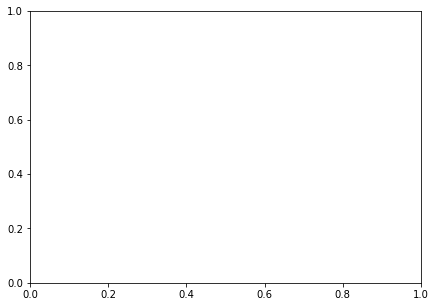

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(clust_df, x=clust_df.index, y= "plaque", palette=sort_col, order=sort_clust) 
#label x axis
plt.ylabel('Plaque number', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
#plt.savefig(s_fig + 'plaque-clusters-barplot.svg', transparent=True)
plt.show()

In [19]:
# Fraction of spots covered by plaque

#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()
for x,name in enumerate(sub_ID):
    spot_df, gene_df = run_('old',ID[x], sub_ID[x])
    curr= (spot_df.groupby('cluster').sum()['plaque']/spot_df.groupby('cluster').count()['plaque'])*100
    cat_df = pd.concat([cat_df, curr])

cat_df = cat_df.reset_index()
cat_df.columns = ['cluster', 'plaque']


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3397
Number of genes: 32284


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2835
Number of genes: 32284


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2959
Number of genes: 32284


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3204
Number of genes: 32284


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3406
Number of genes: 32284


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3002
Number of genes: 32284


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2998
Number of genes: 32284


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3343
Number of genes: 32284


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3285
Number of genes: 32284


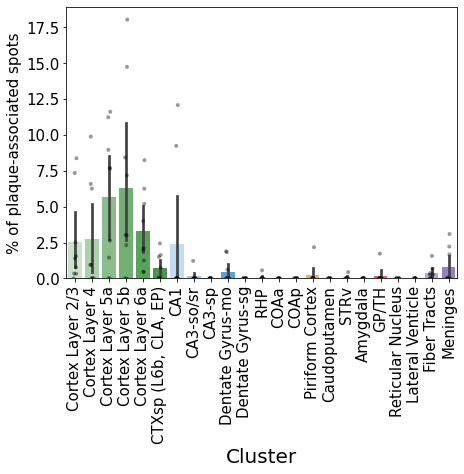

In [40]:

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(data=cat_df, x='cluster', y='plaque',palette=sort_col, order=sort_clust) 

sns.stripplot(
    x="cluster", 
    y="plaque", 
    color='k', order=sort_clust,
    data=cat_df, alpha=0.4, size=4
)

#label x axis
plt.ylabel('% of plaque-associated spots', fontsize=15)
plt.xlabel('Cluster', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(s_code + 'spatial_transcriptomics/' + 'prac.svg', transparent=True)
plt.show()

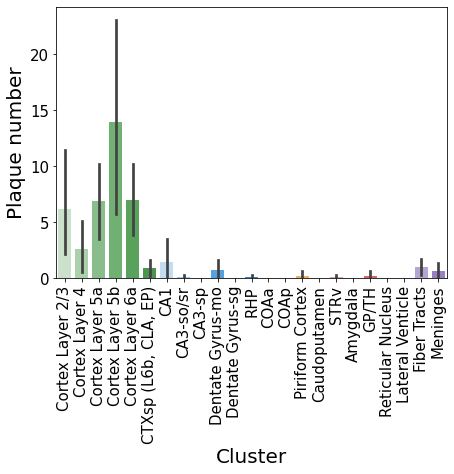

In [44]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(cat_df, x='cluster', y= "plaque", palette=sort_col, order=sort_clust) 
#label x axis
plt.ylabel('Plaque number', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
#plt.savefig(s_fig + 'plaque-clusters-barplot.svg', transparent=True)
plt.show()

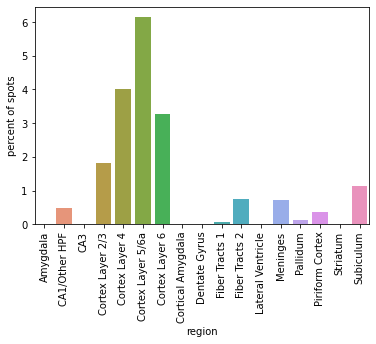

In [105]:
sns.barplot(clust_df, x='region', y= "percent of spots", order=clust_df.sort_values('region', ascending=True).region)# hue="sex", stat="probability", multiple="fill", shrink=.8)
plt.xticks(rotation=90)
plt.show()

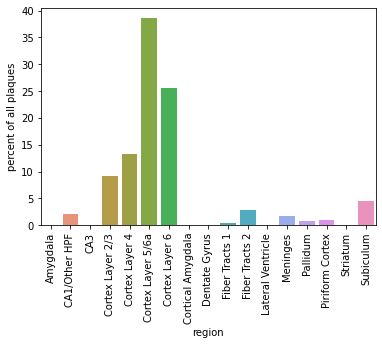

In [106]:
sns.barplot(clust_df, x='region', y= "percent of all plaques", order=clust_df.sort_values('region', ascending=True).region)# hue="sex", stat="probability", multiple="fill", shrink=.8)
plt.xticks(rotation=90)
plt.show()

In [292]:
cat_df

,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,plaque,cluster,anot
114443,AAACAATCTACTAGCA-1,1,3,43,1036,506,0,7,Cortex Layer 2/3
114444,AAACACCAATAACTGC-1,1,59,19,1290,1553,0,8,CA3
114445,AAACAGCTTTCAGAAG-1,1,43,9,1399,1255,0,13,Cortical Amygdala
114446,AAACAGGGTCTATATT-1,1,47,13,1355,1329,0,13,Cortical Amygdala
114447,AAACAGTGTTCCTGGG-1,1,73,43,1032,1814,0,16,Meninges
...,...,...,...,...,...,...,...,...,...
138352,TTGTTTCACATCCAGG-1,1,58,42,1048,1875,0,3,Cortex Layer 6
138353,TTGTTTCATTAGTCTA-1,1,60,30,1175,1912,0,1,Cortex Layer 5/6a
138354,TTGTTTCCATACAACT-1,1,45,27,1207,1636,0,7,Cortex Layer 2/3
138355,TTGTTTGTATTACACG-1,1,73,41,1057,2151,0,1,Cortex Layer 5/6a


In [6]:
#Look at distribution of spots across sample
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()
for x,name in enumerate(sub_ID):
    spot_df, gene_df = run_(ID[x], sub_ID[x])
    spot_df['sample id'] = np.full(len(spot_df), name)
    cat_df = pd.concat([cat_df, spot_df])

cat_filt = cat_df[cat_df['plaque'] == 1]
cat_filt

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2959
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3397
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2998
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3204
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3406
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2835
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3002
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3343
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3285
Number of genes: 32284


,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,plaque,cluster,sample id
165822,AACTCCAGAGCGTGTT-1,1,60,92,510,1712,1,Cortex Layer 5a,109-D
165877,AATACCGGAGGGCTGT-1,1,67,37,1105,1846,1,Piriform Cortex,109-D
165926,ACAAGGATGCTTTAGG-1,1,61,87,564,1731,1,Cortex Layer 5b,109-D
165959,ACATGGCGCCAAAGTA-1,1,40,104,382,1335,1,Cortex Layer 5b,109-D
166019,ACGCAAACTAATAGAT-1,1,63,47,997,1770,1,"CTXsp (L6b, CLA, EP)",109-D
...,...,...,...,...,...,...,...,...,...
130476,TCACGATGTCCGTGGA-1,1,52,28,1196,1765,1,Cortex Layer 2/3,040-D
130516,TCCCAAACATCCTCTA-1,1,75,35,1121,2188,1,Cortex Layer 2/3,040-D
130571,TCGAGCCAGGCAGGCC-1,1,57,37,1101,1857,1,Cortex Layer 5b,040-D
131004,TTCTTGGACGATCTGC-1,1,52,32,1154,1765,1,Cortex Layer 5a,040-D


In [27]:
from PIL import ImageColor
rgb_l = [ImageColor.getcolor(sort_col[i], "RGBA") for i in range(len(sort_col))]
rgb_l=np.asarray(rgb_l) / 255

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


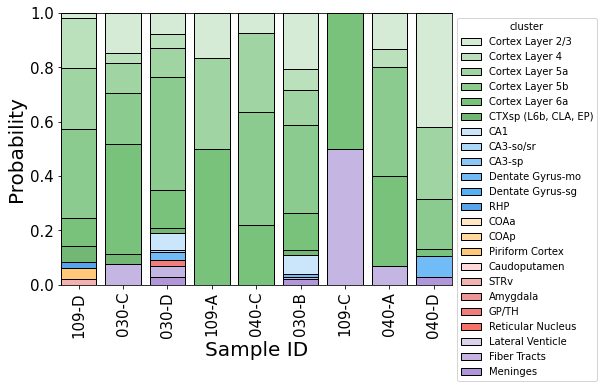

In [29]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(cat_filt, x="sample id", hue="cluster", hue_order = sort_clust, palette=rgb_l, stat='probability', multiple="fill", shrink=.8)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Probability', fontsize=20)
plt.xlabel('Sample ID', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(s_fig + 'plaque-clusters-propplot.svg', transparent=True)
plt.show()

In [33]:
cort_clust = sort_clust[:5]
cort_clust

0    Cortex Layer 2/3
1      Cortex Layer 4
2     Cortex Layer 5a
3     Cortex Layer 5b
4     Cortex Layer 6a
Name: cluster_order, dtype: object

In [31]:
#Find shortest path right_most and left_most points in layer 2-3
#-----------------------------------------------
def add_edge(graph, my_coords, nn):
    #compute distances between all points
    #-----------------------------------------------

    from sklearn.neighbors import NearestNeighbors
    #find the n nearest neighbours
    X = np.asarray(my_coords)
    nbrs = NearestNeighbors(n_neighbors=nn, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = distances[:,1:]
    indices = indices[:,1:]

    #fill in graph
    edges = list(range(distances.shape[0]*distances.shape[1]))
    count=0
    for i in range(distances.shape[0]):
        for e in range(distances.shape[1]):
            edges[count] = (str(i), str(indices[i,e]), 1/distances[i,e])
            count+=1
    for edge in edges:
        graph.add_edge(*edge)
    return(graph)

#Calculate R->C ratio
def nn_check(X, new_path):
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = distances[:,1:]
    indices = indices[:,1:]
    norm_dist = indices[0][0]/len(new_path) 
    if norm_dist == 0:
        norm_dist = indices[0][1]/len(new_path) 
    return(norm_dist)

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3397
Number of genes: 32284


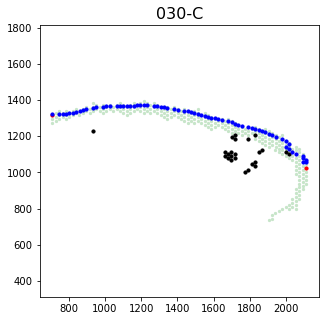

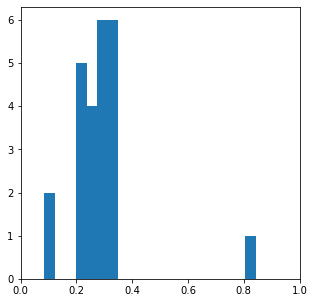

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2835
Number of genes: 32284


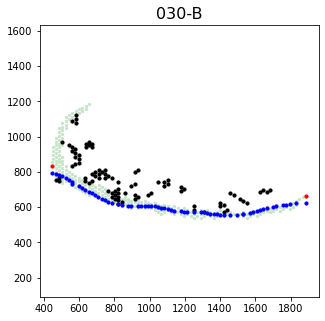

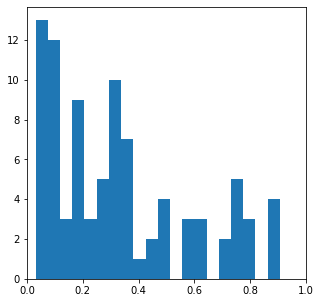

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2959
Number of genes: 32284


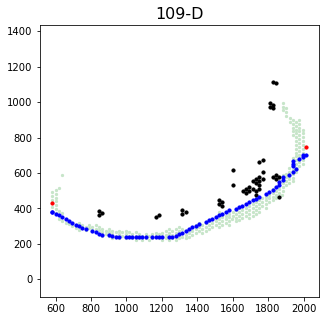

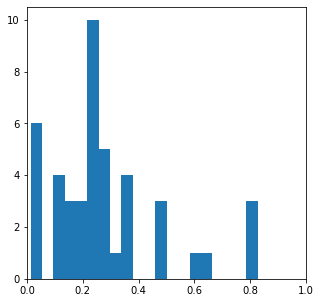

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3204
Number of genes: 32284


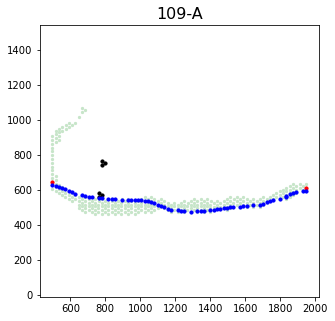

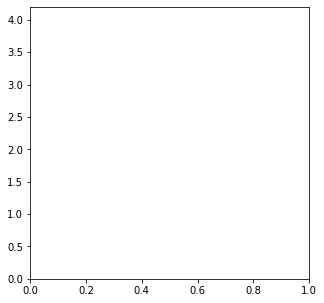

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3406
Number of genes: 32284


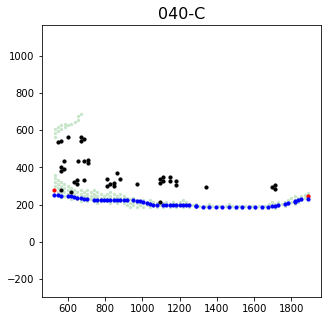

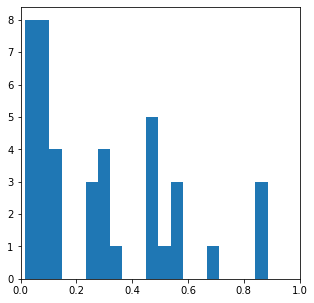

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3002
Number of genes: 32284


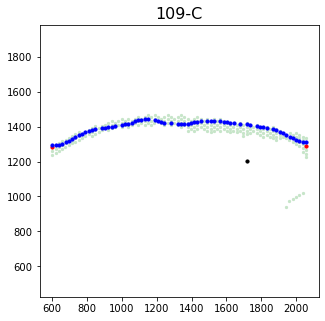

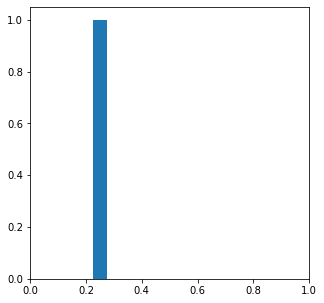

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2998
Number of genes: 32284


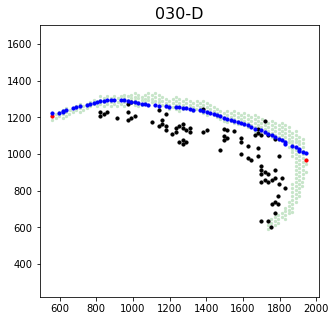

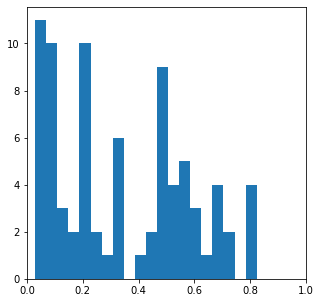

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3343
Number of genes: 32284


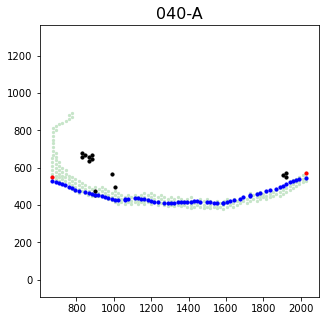

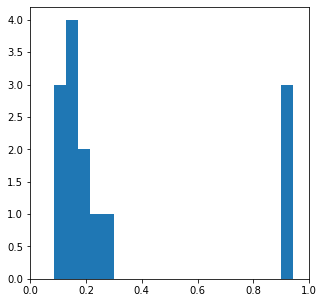

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3285
Number of genes: 32284


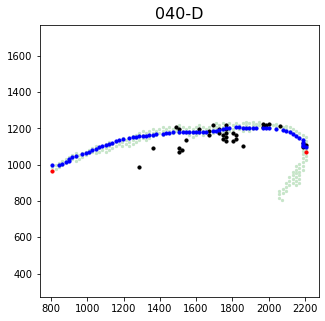

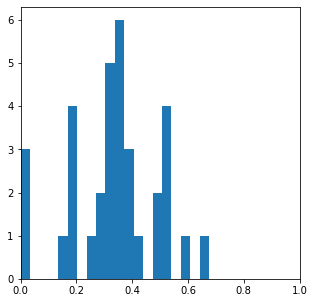

In [36]:
import scipy
from sklearn.neighbors import NearestNeighbors

invert_name = ['030-B', '109-A', '040-C', '040-A']
samp_l = list(range(len(sub_ID)))
flat=[]
nom=[]
#plot and save all samples
for y,name in enumerate(sub_ID):
    #plot and save all samples
    spot_df, gene_df = run_('old',ID[y], sub_ID[y])
    clust_lab = spot_df['cluster'].values
    ycoord, xcoord = spot_df['pxl_row_in_fullres'].values, spot_df['pxl_col_in_fullres'].values
    plq_bool = spot_df['plaque'].values == 1
    plq_bool = np.intersect1d(np.argwhere(plq_bool), [i for i in range(len(spot_df['cluster'])) if 'Cortex' in spot_df['cluster'].values[i]])


    fig,ax = plt.subplots(figsize=(5,5))
    #only do top cortex cluster
    x=0
    plt.scatter(xcoord[np.where(clust_lab==cort_clust[x])[0]], ycoord[np.where(clust_lab==cort_clust[x])[0]], s=5, label = cort_clust[x], color = sort_col[x], alpha=1)
    plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
    curr_x = xcoord[np.where(clust_lab==cort_clust[x])[0]]
    curr_y = ycoord[np.where(clust_lab==cort_clust[x])[0]]
    right_most = np.max(curr_x)
    left_most = np.min(curr_x)
    
    #find shortest path length
    end_ind, start_ind = str(np.where(curr_x==right_most)[0][0]),str(np.where(curr_x==left_most)[0][0])
    my_coords = np.vstack((curr_x,curr_y)).T
    graph = pf.Graph()
    graph = add_edge(graph,my_coords, 5)
    path = pf.dijsktra(graph, start_ind, end_ind)


    #color right_most and left_most point
    plt.scatter(right_most, curr_y[np.where(curr_x==right_most)[0]][0],s=10, c='r')
    plt.scatter(left_most, curr_y[np.where(curr_x==left_most)[0]][0],  s=10, c='r')

    #color shortest path and gaussian smooth in y
    path_x, path_y = curr_x[[int(i) for i in path]], curr_y[[int(i) for i in path]]
    arr = np.asarray(np.vstack((path_x, path_y)).T)
    arr = arr.astype('int32')
    new_arr= scipy.ndimage.gaussian_filter(arr[:,1], sigma=3)

    plt.scatter(path_x, new_arr, s=10, c='blue')

    #remove all borders
    ax.axis('equal')
    plt.title(sub_ID[y], fontsize=16)
    plt.show()

    
    #Calculate distances R-> C
    dist_v = []
    new_path = np.vstack((path_x, new_arr)).T
    new_plq = np.vstack((xcoord[plq_bool],ycoord[plq_bool])).T
    for p in new_plq:
        dist_v = np.append(dist_v,nn_check(np.vstack((p,new_path)), new_path))
        
    if name not in invert_name:
        dist_v = 1-dist_v
    flat = np.append(flat,dist_v)
    nom = np.append(nom, np.full(len(dist_v), name))
    
    fig,ax = plt.subplots(figsize=(5,5))
    plt.hist(dist_v, bins=20)
    plt.xlim(0,1)
    plt.show()

In [37]:
df = pd.DataFrame({'name':nom, 'Rostral/Caudal': flat})
df

,name,Rostral/Caudal
0,030-C,0.214286
1,030-C,0.300000
2,030-C,0.100000
3,030-C,0.314286
4,030-C,0.328571
...,...,...
328,040-D,0.323944
329,040-D,0.028169
330,040-D,0.267606
331,040-D,0.338028


<ipython-input-38-c0c6bae9c001>:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(data=df, x="Rostral/Caudal", hue="name", kind="kde", fill=True, height=6, aspect=1.5)


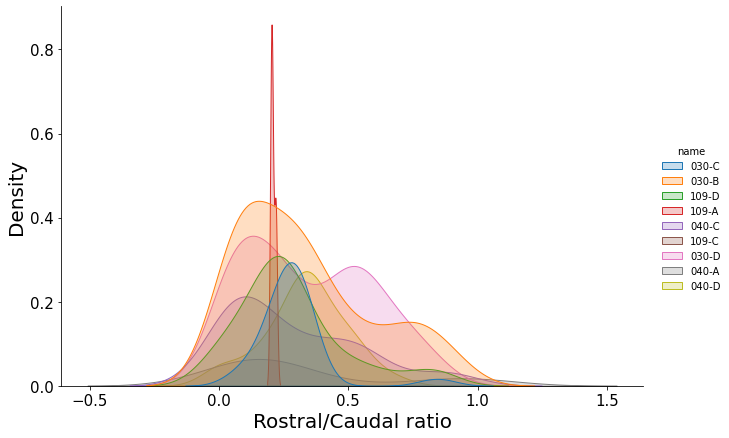

In [38]:
sns.displot(data=df, x="Rostral/Caudal", hue="name", kind="kde", fill=True, height=6, aspect=1.5)
sns.set(rc={'figure.figsize':(20,8.27)})

#label x axis
plt.ylabel('Density', fontsize=20)
plt.xlabel('Rostral/Caudal ratio', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.rcParams['figure.figsize']=(20,6)
#plt.savefig(s_code + 'spatial_transcriptomics/' + 'prac.svg', transparent=False)
plt.show()


In [369]:
#YOUNG ANIMALS
#sort out names
import glob
import os
age = 'young'
os.chdir('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/coords/' + age)
og = glob.glob('*.json')
ID = [i.split('.')[0] for i in og]
sub_ID=[]
for x,i in enumerate(og):
     sub_ID = np.append(sub_ID, i.split('_')[1][:-5])
ID, sub_ID



(['V10Y05_107-D', 'V10Y07_063-B', 'V10Y05_106-C'],
 array(['107-D', '063-B', '106-C'], dtype='<U32'))

/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3311
Number of genes: 32284


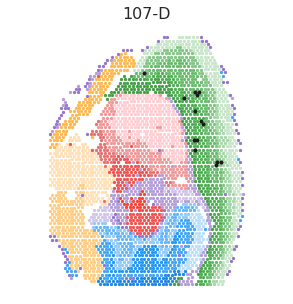

/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3570
Number of genes: 32284


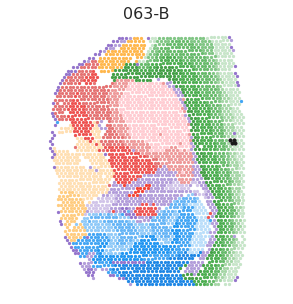

/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3151
Number of genes: 32284


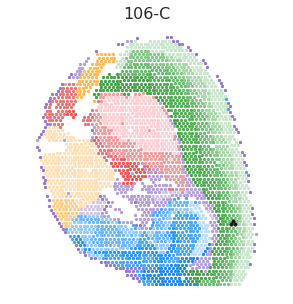

In [373]:

#plot and save all samples
for y,name in enumerate(sub_ID):
    sns.set_style(style='white') 
    spot_df, gene_df = run_('young',ID[y], sub_ID[y])
    clust_lab = spot_df['cluster'].values
    xcoord, ycoord = spot_df['pxl_row_in_fullres'].values, spot_df['pxl_col_in_fullres'].values
    plq_bool = spot_df['plaque'].values == 1


    fig,ax = plt.subplots(figsize=(5,5))
    for x in range(len(sort_clust)): 
        plt.scatter(xcoord[np.where(clust_lab==sort_clust[x])[0]], ycoord[np.where(clust_lab==sort_clust[x])[0]], s=5, label = sort_clust[x], color = sort_col[x], alpha=1)
    plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, markerscale=2)

    #remove all borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.axis('equal')
    ax.grid(False)
    plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    plt.title(sub_ID[y], fontsize=16)
    plt.savefig(s_code + 'spatial_transcriptomics/plaque-clusters-' + sub_ID[y] + '.svg', transparent=True)
    plt.show()


In [375]:
# Fraction of spots covered by plaque

#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()
for x,name in enumerate(sub_ID):
    spot_df, gene_df = run_('young',ID[x], sub_ID[x])
    curr= (spot_df.groupby('cluster').sum()['plaque']/spot_df.groupby('cluster').count()['plaque'])*100
    cat_df = pd.concat([cat_df, curr])

cat_df = cat_df.reset_index()
cat_df.columns = ['cluster', 'plaque']


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3311
Number of genes: 32284


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3570
Number of genes: 32284


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3151
Number of genes: 32284


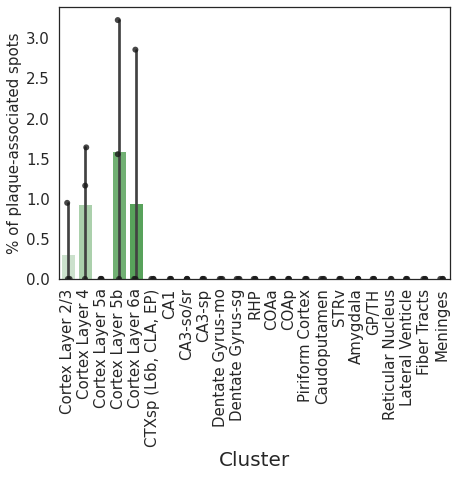

In [379]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(data=cat_df, x='cluster', y='plaque',palette=sort_col, order=sort_clust) 

sns.stripplot(
    x="cluster", 
    y="plaque", 
    color='k', order=sort_clust,
    data=cat_df, alpha=0.8, size=6
)

#label x axis
plt.ylabel('% of plaque-associated spots', fontsize=15)
plt.xlabel('Cluster', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(s_code + 'spatial_transcriptomics/' + 'prac.svg', transparent=True)
plt.show()

In [381]:
#Look at distribution of spots across sample
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()
for x,name in enumerate(sub_ID):
    spot_df, gene_df = run_('young',ID[x], sub_ID[x])
    spot_df['sample id'] = np.full(len(spot_df), name)
    cat_df = pd.concat([cat_df, spot_df])

cat_filt = cat_df[cat_df['plaque'] == 1]
cat_filt

/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3311
Number of genes: 32284


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3570
Number of genes: 32284


/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3151
Number of genes: 32284


,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,plaque,cluster,sample id
62020,AATTCGATTCGAGGAT-1,1,66,76,992,3601,1,Cortex Layer 5b,107-D
62096,ACCCATCTTGAGGGTA-1,1,37,37,1198,3337,1,Cortex Layer 5b,107-D
62100,ACCCGGTTACACTTCC-1,1,42,48,1140,3382,1,Cortex Layer 6a,107-D
62101,ACCCGTGTCATCAGTA-1,1,58,54,1108,3528,1,Cortex Layer 6a,107-D
62404,AGTGATATGAGTAGTT-1,1,45,49,1135,3409,1,Cortex Layer 6a,107-D
62522,ATCCTGCGTGGAATGG-1,1,45,47,1145,3409,1,Cortex Layer 6a,107-D
62776,CAGAGGCGATGCATGA-1,1,54,48,1140,3492,1,Cortex Layer 6a,107-D
62974,CCGCGGAATGCGTCAC-1,1,51,45,1156,3464,1,Cortex Layer 6a,107-D
63551,GACGCTTGCTTCTAAA-1,1,38,36,1203,3346,1,Cortex Layer 5b,107-D
64077,GTAATCTGATTCTTCG-1,1,50,44,1161,3455,1,Cortex Layer 5b,107-D


In [382]:
from PIL import ImageColor
rgb_l = [ImageColor.getcolor(sort_col[i], "RGBA") for i in range(len(sort_col))]
rgb_l=np.asarray(rgb_l) / 255


/home/dburrows/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


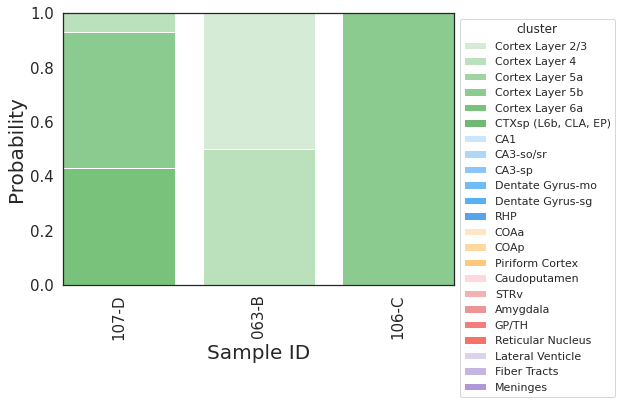

In [383]:

fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(cat_filt, x="sample id", hue="cluster", hue_order = sort_clust, palette=rgb_l, stat='probability', multiple="fill", shrink=.8)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Probability', fontsize=20)
plt.xlabel('Sample ID', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(s_code + '/spatial_transcriptomics/plaque-clusters-propplot.svg', transparent=True)
plt.show()

/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3311
Number of genes: 32284


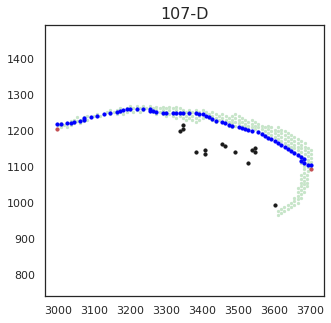

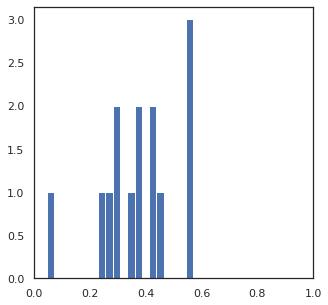

/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3570
Number of genes: 32284


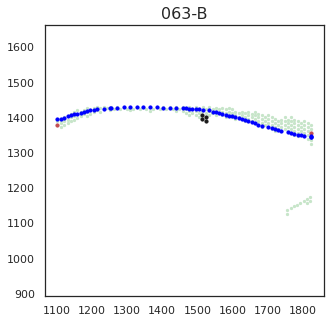

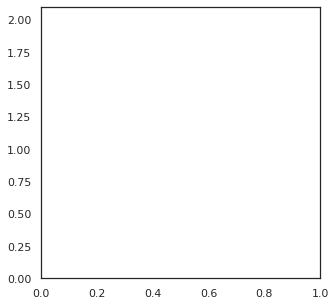

/home/dburrows/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3151
Number of genes: 32284


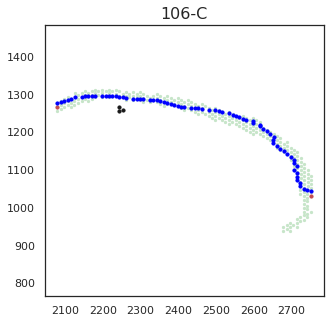

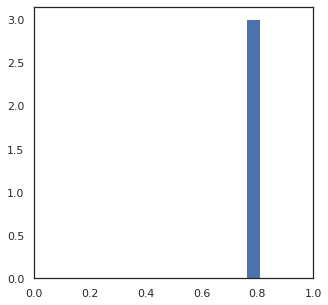

In [388]:
invert_name = ['030-B', '109-A', '040-C', '040-A']
samp_l = list(range(len(sub_ID)))
flat=[]
nom=[]
#plot and save all samples
for y,name in enumerate(sub_ID):
    #plot and save all samples
    spot_df, gene_df = run_('young',ID[y], sub_ID[y])
    clust_lab = spot_df['cluster'].values
    ycoord, xcoord = spot_df['pxl_row_in_fullres'].values, spot_df['pxl_col_in_fullres'].values
    plq_bool = spot_df['plaque'].values == 1
    plq_bool = np.intersect1d(np.argwhere(plq_bool), [i for i in range(len(spot_df['cluster'])) if 'Cortex' in spot_df['cluster'].values[i]])


    fig,ax = plt.subplots(figsize=(5,5))
    #only do top cortex cluster
    x=0
    plt.scatter(xcoord[np.where(clust_lab==cort_clust[x])[0]], ycoord[np.where(clust_lab==cort_clust[x])[0]], s=5, label = cort_clust[x], color = sort_col[x], alpha=1)
    plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
    curr_x = xcoord[np.where(clust_lab==cort_clust[x])[0]]
    curr_y = ycoord[np.where(clust_lab==cort_clust[x])[0]]
    right_most = np.max(curr_x)
    left_most = np.min(curr_x)
    
    #find shortest path length
    end_ind, start_ind = str(np.where(curr_x==right_most)[0][0]),str(np.where(curr_x==left_most)[0][0])
    my_coords = np.vstack((curr_x,curr_y)).T
    graph = pf.Graph()
    graph = add_edge(graph,my_coords, 5)
    path = pf.dijsktra(graph, start_ind, end_ind)


    #color right_most and left_most point
    plt.scatter(right_most, curr_y[np.where(curr_x==right_most)[0]][0],s=10, c='r')
    plt.scatter(left_most, curr_y[np.where(curr_x==left_most)[0]][0],  s=10, c='r')

    #color shortest path and gaussian smooth in y
    path_x, path_y = curr_x[[int(i) for i in path]], curr_y[[int(i) for i in path]]
    arr = np.asarray(np.vstack((path_x, path_y)).T)
    arr = arr.astype('int32')
    new_arr= scipy.ndimage.gaussian_filter(arr[:,1], sigma=3)

    plt.scatter(path_x, new_arr, s=10, c='blue')

    #remove all borders
    ax.axis('equal')
    plt.title(sub_ID[y], fontsize=16)
    plt.show()

    
    #Calculate distances R-> C
    dist_v = []
    new_path = np.vstack((path_x, new_arr)).T
    new_plq = np.vstack((xcoord[plq_bool],ycoord[plq_bool])).T
    for p in new_plq:
        dist_v = np.append(dist_v,nn_check(np.vstack((p,new_path)), new_path))
        
    dist_v = 1-dist_v
    flat = np.append(flat,dist_v)
    nom = np.append(nom, np.full(len(dist_v), name))
    
    fig,ax = plt.subplots(figsize=(5,5))
    plt.hist(dist_v, bins=20)
    plt.xlim(0,1)
    plt.show()

In [390]:
df

,name,Rostral/Caudal
0,107-D,0.046154
1,107-D,0.569231
2,107-D,0.446154
3,107-D,0.292308
4,107-D,0.430769
5,107-D,0.430769
6,107-D,0.338462
7,107-D,0.369231
8,107-D,0.569231
9,107-D,0.384615


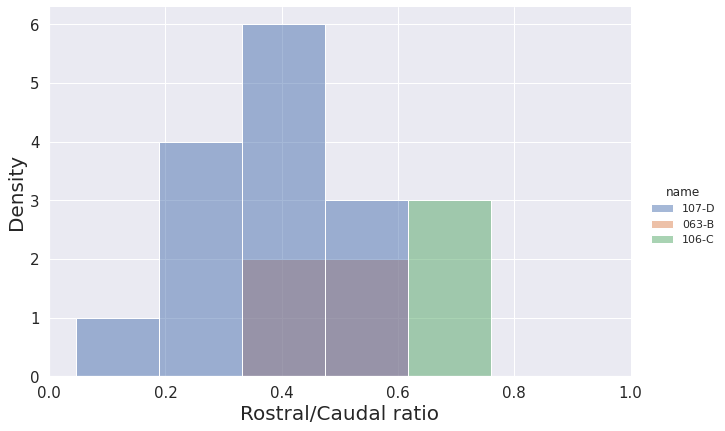

In [397]:
df = pd.DataFrame({'name':nom, 'Rostral/Caudal': flat})


sns.displot(data=df, x="Rostral/Caudal", hue="name", bins = 5,fill=True, height=6, aspect=1.5)

sns.set(rc={'figure.figsize':(20,8.27)})

#label x axis
plt.ylabel('Density', fontsize=20)
plt.xlabel('Rostral/Caudal ratio', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,1)
plt.rcParams['figure.figsize']=(20,6)
plt.savefig(s_code + 'spatial_transcriptomics/' + 'prac.svg', transparent=False)
plt.show()


# Compare adjacent slices for gene expression

In [78]:
og_df, og_gene_df = run_('030-B')
clust_lab = og_df['cluster'].values
reg_lab = np.asarray(og_df.groupby('cluster').first()['anot'])

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2939
Number of genes: 12404


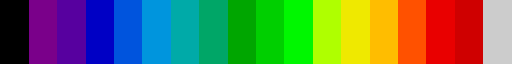

In [79]:
#Choose colormap
cmap = plt.get_cmap("nipy_spectral", len(np.unique(reg_lab))+1)
cmap

In [99]:
distances

array([[21.        , 21.09502311, 21.47091055, ..., 36.7151195 ,
        37.21558813, 37.21558813],
       [21.09502311, 21.09502311, 21.9544984 , ..., 37.21558813,
        38.        , 42.54409477],
       [21.        , 21.09502311, 21.09502311, ..., 37.        ,
        37.21558813, 37.21558813],
       ...,
       [21.        , 21.9544984 , 21.9544984 , ..., 43.        ,
        43.41658669, 43.9089968 ],
       [21.02379604, 21.9544984 , 21.9544984 , ..., 43.01162634,
        43.0464865 , 43.41658669],
       [20.59126028, 21.        , 21.09502311, ..., 37.        ,
        37.21558813, 37.21558813]])

In [100]:
1/distances

array([[0.04761905, 0.04740455, 0.04657464, ..., 0.02723674, 0.02687046,
        0.02687046],
       [0.04740455, 0.04740455, 0.04554875, ..., 0.02687046, 0.02631579,
        0.02350502],
       [0.04761905, 0.04740455, 0.04740455, ..., 0.02702703, 0.02687046,
        0.02687046],
       ...,
       [0.04761905, 0.04554875, 0.04554875, ..., 0.02325581, 0.02303267,
        0.02277438],
       [0.04756515, 0.04554875, 0.04554875, ..., 0.02324953, 0.0232307 ,
        0.02303267],
       [0.04856429, 0.04761905, 0.04740455, ..., 0.02702703, 0.02687046,
        0.02687046]])

In [80]:
name = '030-B'
data_path = s_data + 'spatial_transcriptomics/plaques/' + name + 'X.json'
coord_path = '/cndd2/agelber/hal/qc_aligned/' + name + '/outs/spatial/tissue_positions.csv'
genes_path = '/cndd2/agelber/hal/qc_aligned/' + name + '/outs/filtered_feature_bc_matrix.h5'
meta = pd.read_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/allspots_meta.csv') #FILTERED
meta_filt = meta[meta['sample'] == name]

spot_df, gene_df = pf.sort_data(data_path, coord_path, genes_path, 
                                meta_filt, min_cell_per_gene=100, norm_factor=1e6)

#Sanity check
assert spot_df.shape[0] == gene_df.shape[0] == meta_filt.shape[0]
assert 'Thy1' not in gene_df.columns.values or 'humanAPP' not in gene_df.columns.values
print('Number of spots: ' + str(gene_df.shape[0]))
print('Number of genes: ' + str(gene_df.shape[1]))

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2939
Number of genes: 12404


In [58]:
#plot and save all samples

xcoord, ycoord = spot_df['array_row'].values, spot_df['array_col'].values
plq_bool = spot_df['plaque'].values == 1


fig,ax = plt.subplots(figsize=(5,5))
for x in range(len(np.unique(clust_lab))): 
    plt.scatter(xcoord[np.where(clust_lab==x)[0]], ycoord[np.where(clust_lab==x)[0]], s=5, label = reg_lab[x], color = cmap(x+1), alpha=1)
plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, markerscale=2)

#remove all borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

plt.savefig(s_fig + 'plaque-clusters-' + name + '.svg', transparent=True)
plt.show()


(2939,)

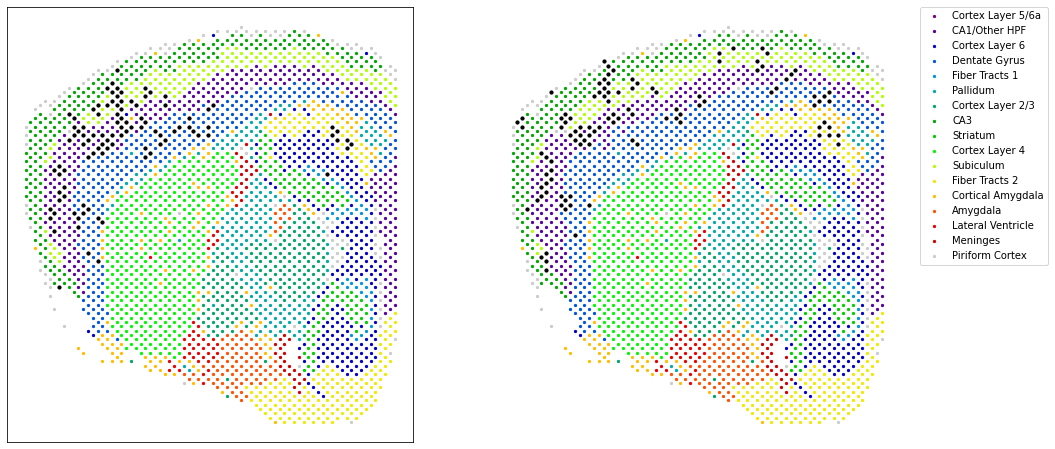

In [84]:
#PLOT PLAQUES
data_l = og_df, spot_df
fig,ax = plt.subplots(1, 2, figsize=(16,8))

for i,data in enumerate(data_l):
    xcoord, ycoord = data['array_row'].values, data['array_col'].values
    plq_bool = data['plaque'].values == 1
    clust_lab = data['cluster'].values
    for x in range(len(np.unique(clust_lab))): 
        ax[i].scatter(xcoord[np.where(clust_lab==x)[0]], ycoord[np.where(clust_lab==x)[0]], s=5, label = reg_lab[x], color = cmap(x+1), alpha=1)
    ax[i].scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
    ax[i].xaxis.set_tick_params(labelbottom=False)
    ax[i].yaxis.set_tick_params(labelleft=False)
    ax[i].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [127]:
#original ordering of cluster
col_ord = og_df.groupby('cluster').first()['anot']

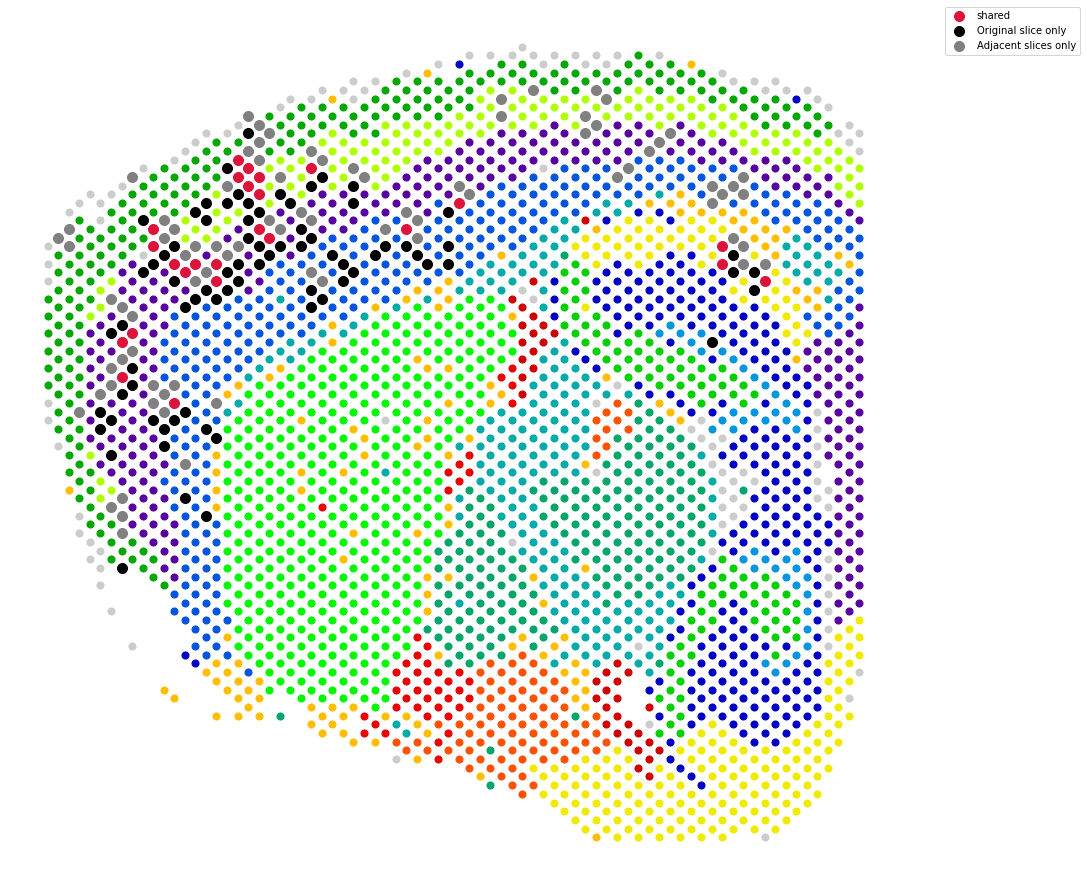

In [553]:
#PLOT OVERLAPPING PLAQUES
og_plq = np.where(og_df['plaque']==1)[0]
new_plq = np.where(spot_df['plaque']==1)[0]
shared = np.intersect1d(og_plq, new_plq)
og_notin = np.setxor1d(og_plq, shared)
new_notin = np.setxor1d(new_plq, shared)

assert len(og_plq) == len(og_notin) + len(shared)
assert len(new_plq) == len(new_notin) + len(shared)
data = og_df

fig,ax = plt.subplots(figsize=(16,16))
xcoord, ycoord = data['array_row'].values, data['array_col'].values
plq_bool = data['plaque'].values == 1
clust_lab = data['cluster'].values
for x in range(len(np.unique(clust_lab))): 
    plt.scatter(xcoord[np.where(clust_lab==x)[0]], ycoord[np.where(clust_lab==x)[0]], s=50, color = cmap(x+1), alpha=1)

plt.scatter(xcoord[shared], ycoord[shared], s=100, c='crimson', label='shared')
plt.scatter(xcoord[og_notin], ycoord[og_notin], s=100, c='k', label='Original slice only')
plt.scatter(xcoord[new_notin], ycoord[new_notin], s=100, c='grey', label='Adjacent slices only')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig(s_fig + 'plaque-overlap.svg', transparent=True)
plt.show()


In [76]:
#find euclidean distance between all points
my_coords = np.vstack((curr_x, curr_y)).T
len(my_coords)

287

In [ ]:
[]

In [341]:
cort_l = 'Cortex Layer 2/3', 'Cortex Layer 4', 'Cortex Layer 5/6a', 'Cortex Layer 6'

In [433]:
cort_l

('Cortex Layer 2/3', 'Cortex Layer 4', 'Cortex Layer 5/6a', 'Cortex Layer 6')

In [435]:
clust_lab

array(['Cortex Layer 2/3', 'CA3', 'Cortical Amygdala', ..., 'Pallidum',
       'Meninges', 'Cortex Layer 5/6a'], dtype=object)

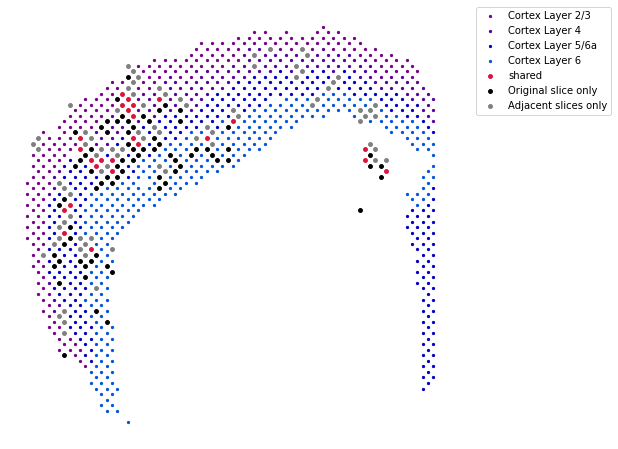

In [436]:
#PLOT OVERLAPPING PLAQUES
og_plq = np.where(og_df['plaque']==1)[0]
new_plq = np.where(spot_df['plaque']==1)[0]
shared = np.intersect1d(og_plq, new_plq)
og_notin = np.setxor1d(og_plq, shared)
new_notin = np.setxor1d(new_plq, shared)

assert len(og_plq) == len(og_notin) + len(shared)
assert len(new_plq) == len(new_notin) + len(shared)
data = og_df

fig,ax = plt.subplots(figsize=(8,8))
xcoord, ycoord = data['array_row'].values, data['array_col'].values
plq_bool = data['plaque'].values == 1
clust_lab = data['anot'].values
for y,x in enumerate(cort_l):
    plt.scatter(xcoord[np.where(clust_lab==x)[0]], ycoord[np.where(clust_lab==x)[0]], s=5, label = x, color = cmap(y+1), alpha=1)

plt.scatter(xcoord[shared], ycoord[shared], s=15, c='crimson', label='shared')
plt.scatter(xcoord[og_notin], ycoord[og_notin], s=15, c='k', label='Original slice only')
plt.scatter(xcoord[new_notin], ycoord[new_notin], s=15, c='grey', label='Adjacent slices only')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [137]:
new_ord_col = [col_v[np.where(np.unique(cat_filt['anot'])[i] == col_ord)[0][0]] for i in range(len(np.unique(cat_filt['anot'])))]
new_ord_col

[(0.0, 0.6510058823529412, 0.40781764705882395, 1.0),
 (0.0, 0.9686352941176471, 0.0, 1.0),
 (0.4784529411764706, 0.0, 0.5450705882352941, 1.0),
 (0.0, 0.0, 0.7725823529411764, 1.0),
 (0.9411470588235293, 0.9176176470588236, 0.0, 1.0),
 (0.6901647058823523, 1.0, 0.0, 1.0)]

<ipython-input-554-ed3b8b8a1c29>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']


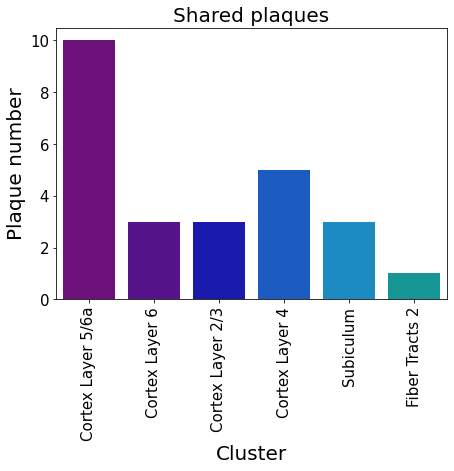

In [554]:
#Look at distribution of plaques across clusters
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()

cat_df = og_df.iloc[shared]
clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']
clust_df['region'] = cat_df.groupby('cluster').first()['anot']
clust_df['total spots'] = cat_df.groupby('cluster').count()['plaque']
clust_df['percent of spots'] = clust_df['plaque']/clust_df['total spots'] *100
clust_df['percent of spots'] = clust_df['percent of spots'].round(2)
clust_df['percent of all plaques'] = clust_df['plaque']/clust_df['plaque'].sum() *100
clust_df['percent of all plaques'] = clust_df['percent of all plaques'].round(2)


fig, ax = plt.subplots(figsize=(7,5))
plt.title('Shared plaques', fontsize=20)
sns.barplot(clust_df, x='region', y= "plaque", palette=col_v)# order=clust_df.sort_values('region', ascending=True).region, palette=z) 
#label x axis
plt.ylabel('Plaque number', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(s_fig + 'plaque-overlap-barplot.svg', transparent=True)
plt.show()

<ipython-input-555-27b705883cfc>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']


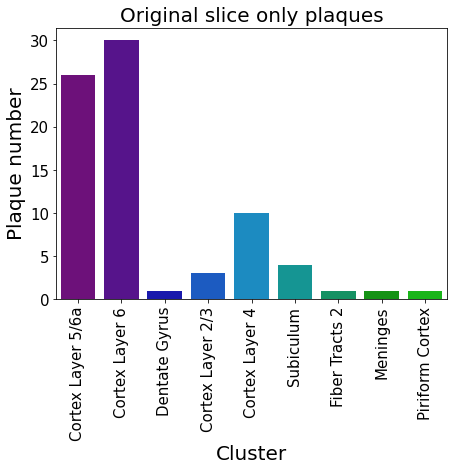

In [555]:
#Look at distribution of plaques across clusters
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()

cat_df = og_df.iloc[og_notin]
clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']
clust_df['region'] = cat_df.groupby('cluster').first()['anot']
clust_df['total spots'] = cat_df.groupby('cluster').count()['plaque']
clust_df['percent of spots'] = clust_df['plaque']/clust_df['total spots'] *100
clust_df['percent of spots'] = clust_df['percent of spots'].round(2)
clust_df['percent of all plaques'] = clust_df['plaque']/clust_df['plaque'].sum() *100
clust_df['percent of all plaques'] = clust_df['percent of all plaques'].round(2)

fig, ax = plt.subplots(figsize=(7,5))
plt.title('Original slice only plaques', fontsize=20)
sns.barplot(clust_df, x='region', y= "plaque",palette=col_v)# order=clust_df.sort_values('region', ascending=True).region, palette=z) 
#label x axis
plt.ylabel('Plaque number', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(s_fig + 'plaque-sliceonly-barplot.svg', transparent=True)
plt.show()

<ipython-input-556-f1dee2f2b8ed>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']


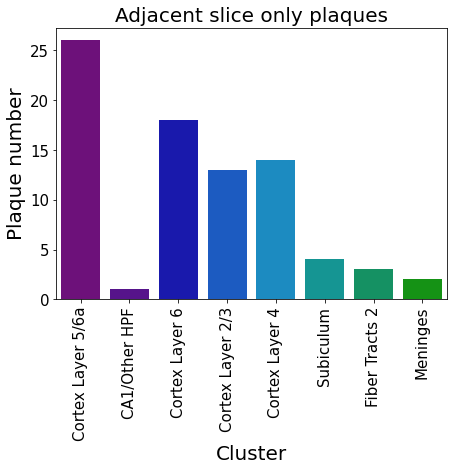

In [556]:
#Look at distribution of plaques across clusters
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()

cat_df = spot_df.iloc[new_notin]
clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']
clust_df['region'] = cat_df.groupby('cluster').first()['anot']
clust_df['total spots'] = cat_df.groupby('cluster').count()['plaque']
clust_df['percent of spots'] = clust_df['plaque']/clust_df['total spots'] *100
clust_df['percent of spots'] = clust_df['percent of spots'].round(2)
clust_df['percent of all plaques'] = clust_df['plaque']/clust_df['plaque'].sum() *100
clust_df['percent of all plaques'] = clust_df['percent of all plaques'].round(2)

fig, ax = plt.subplots(figsize=(7,5))
plt.title('Adjacent slice only plaques', fontsize=20)
sns.barplot(clust_df, x='region', y= "plaque",palette=col_v)# order=clust_df.sort_values('region', ascending=True).region, palette=z) 
#label x axis
plt.ylabel('Plaque number', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(s_fig + 'plaque-adjacentonly-barplot.svg', transparent=True)
plt.show()

In [144]:
#Look at distribution of spots across sample
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()
data_l = og_df, spot_df
name_l = 'Original', 'Adjacent'

for x,data in enumerate(data_l):
    data['sample id'] = np.full(len(data), name_l[x])
    cat_df = pd.concat([cat_df, data])


In [145]:
cat_filt = cat_df[cat_df['plaque'] == 1]
cat_filt

,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,plaque,cluster,anot,sample id
114462,AAAGACCCAAGTCGCG-1,1,10,48,982,637,1,3,Cortex Layer 6,Original
114490,AACACGACTGTACTGA-1,1,9,65,799,617,1,1,Cortex Layer 5/6a,Original
114505,AACCGAGCTTGGTCAT-1,1,24,70,745,897,1,1,Cortex Layer 5/6a,Original
114506,AACCGTTGTGTTTGCT-1,1,12,64,810,674,1,1,Cortex Layer 5/6a,Original
114526,AACTGATATTAGGCCT-1,1,16,66,788,748,1,1,Cortex Layer 5/6a,Original
...,...,...,...,...,...,...,...,...,...,...
117236,TTATATTTGGCAATCC-1,1,26,64,809,935,1,3,Cortex Layer 6,Adjacent
117261,TTCATGGCGCAACAGG-1,1,19,75,691,804,1,10,Cortex Layer 4,Adjacent
117301,TTCTTCCCTTTGATAT-1,1,2,70,746,486,1,7,Cortex Layer 2/3,Adjacent
117352,TTGGGAAGACGAGCCG-1,1,68,64,807,1720,1,11,Subiculum,Adjacent


In [121]:
new_ord_col = [col_v[np.where(np.unique(cat_filt['anot'])[i] == cat_df.groupby('cluster').first()['anot'])[0][0]] for i in range(len(np.unique(cat_filt['anot'])))]
new_ord_col

[(0.3450764705882353, 0.0, 0.6235411764705882, 1.0),
 (0.0, 0.6510058823529412, 0.40781764705882395, 1.0),
 (0.0, 0.9686352941176471, 0.0, 1.0),
 (0.4784529411764706, 0.0, 0.5450705882352941, 1.0),
 (0.0, 0.0, 0.7725823529411764, 1.0),
 (0.0, 0.329435294117647, 0.8667, 1.0),
 (0.9411470588235293, 0.9176176470588236, 0.0, 1.0),
 (0.8117705882352941, 0.0, 0.0, 1.0),
 (0.8, 0.8, 0.8, 1.0),
 (0.6901647058823523, 1.0, 0.0, 1.0)]

<ipython-input-557-19a54b62beaa>:2: UserWarning: The palette list has more values (17) than needed (10), which may not be intended.
  sns.histplot(cat_filt, x="sample id", hue="anot", hue_order = np.unique(cat_filt['anot']),palette=col_v, stat='probability', multiple="fill", shrink=.8)


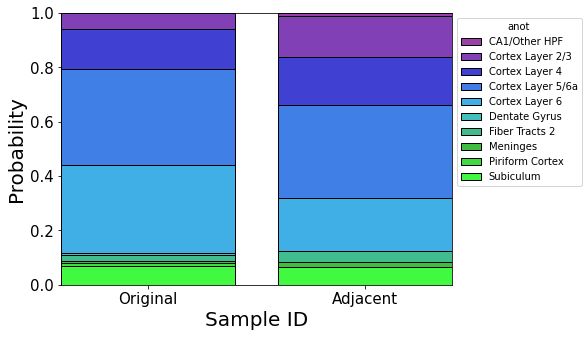

In [557]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(cat_filt, x="sample id", hue="anot", hue_order = np.unique(cat_filt['anot']),palette=col_v, stat='probability', multiple="fill", shrink=.8)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Probability', fontsize=20)
plt.xlabel('Sample ID', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=0)
plt.savefig(s_fig + 'plaque-overlap-propplot.svg', transparent=True)
plt.show()


In [169]:
## Correlate gene expression
og_filt = og_gene_df.loc[(og_df['plaque'] == 1).values]
new_filt = gene_df.loc[(spot_df['plaque'] == 1).values]
no_filt = gene_df.loc[(spot_df['plaque'] == 0).values]
og_filt

,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Rb1cc1,St18,Pcmtd1,...,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,CAAA01118383.1,Vamp7,Spry3,Tmlhe,AC149090.1
AAAGACCCAAGTCGCG-1,0.0,66.577896,0.000000,199.733688,0.000000,0.000000,0.0,66.577896,0.0,66.577896,...,532.623169,8788.282227,1464.713745,133.155792,14580.559570,0.000000,66.577896,66.577896,0.0,266.311584
AACACGACTGTACTGA-1,0.0,74.537865,74.537865,0.000000,0.000000,0.000000,0.0,74.537865,0.0,0.000000,...,447.227173,17814.548828,2012.522339,74.537865,23703.041016,74.537865,0.000000,0.000000,0.0,149.075729
AACCGAGCTTGGTCAT-1,0.0,0.000000,0.000000,0.000000,0.000000,283.559235,0.0,170.135529,0.0,56.711845,...,283.559235,10378.267578,1587.931641,56.711845,16106.164062,0.000000,56.711845,56.711845,0.0,226.847382
AACCGTTGTGTTTGCT-1,0.0,0.000000,81.294205,0.000000,0.000000,162.588409,0.0,0.000000,0.0,0.000000,...,243.882614,7153.890137,975.530457,0.000000,12681.895508,0.000000,0.000000,0.000000,0.0,0.000000
AACTGATATTAGGCCT-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,192.752502,0.0,64.250832,...,257.003326,13364.172852,1991.775757,0.000000,16319.710938,0.000000,64.250832,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTAATCAGTACGTCAG-1,0.0,63.799919,63.799919,63.799919,127.599838,127.599838,0.0,127.599838,0.0,0.000000,...,255.199677,10016.586914,1594.997925,191.399750,15120.581055,0.000000,63.799919,0.000000,0.0,382.799500
TTCATGGCGCAACAGG-1,0.0,104.047455,34.682484,69.364967,0.000000,208.094910,0.0,0.000000,0.0,173.412415,...,485.554779,14115.770508,1907.536621,34.682484,18208.304688,0.000000,0.000000,0.000000,0.0,277.459869
TTCGGTACTGTAGAGG-1,0.0,0.000000,0.000000,0.000000,0.000000,469.836487,0.0,0.000000,0.0,93.967300,...,375.869202,14283.029297,1597.444092,0.000000,16914.113281,0.000000,93.967300,0.000000,0.0,93.967300
TTGGGAAGACGAGCCG-1,0.0,242.522232,242.522232,161.681488,80.840744,161.681488,0.0,161.681488,0.0,80.840744,...,404.203735,18270.007812,2344.381592,161.681488,21665.320312,0.000000,0.000000,0.000000,0.0,242.522232


In [160]:
new_filt

,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Rb1cc1,St18,Pcmtd1,...,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,CAAA01118383.1,Vamp7,Spry3,Tmlhe,AC149090.1
AAAGTCACTGATGTAA-1,0.0,0.000000,55.361790,166.085373,0.000000,55.361790,0.0,166.085373,0.000000,55.361790,...,221.447159,7141.670898,719.703247,110.723579,10961.634766,0.0,0.000000,0.000000,0.0,387.532532
AACTGATATTAGGCCT-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,192.752502,0.000000,64.250832,...,257.003326,13364.172852,1991.775757,0.000000,16319.710938,0.0,64.250832,0.000000,0.0,0.000000
AATCGGGACACTACGA-1,0.0,337.609741,0.000000,0.000000,0.000000,225.073151,0.0,112.536575,0.000000,0.000000,...,225.073151,12379.023438,2025.658325,0.000000,20256.583984,0.0,0.000000,0.000000,0.0,225.073151
AATTCGATTCGAGGAT-1,0.0,0.000000,0.000000,147.666870,0.000000,0.000000,0.0,0.000000,0.000000,147.666870,...,147.666870,10632.014648,1772.002441,147.666870,12256.350586,0.0,147.666870,0.000000,0.0,147.666870
ACACACTTTCTACACG-1,0.0,305.841553,0.000000,0.000000,0.000000,203.894379,0.0,0.000000,0.000000,101.947189,...,203.894379,5097.359375,1019.471924,0.000000,10092.771484,0.0,101.947189,101.947189,0.0,101.947189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTATATTTGGCAATCC-1,0.0,0.000000,0.000000,74.638008,0.000000,74.638008,0.0,0.000000,0.000000,74.638008,...,597.104065,9031.199219,821.018066,74.638008,11792.805664,0.0,0.000000,0.000000,0.0,74.638008
TTCATGGCGCAACAGG-1,0.0,104.047455,34.682484,69.364967,0.000000,208.094910,0.0,0.000000,0.000000,173.412415,...,485.554779,14115.770508,1907.536621,34.682484,18208.304688,0.0,0.000000,0.000000,0.0,277.459869
TTCTTCCCTTTGATAT-1,0.0,0.000000,85.048477,0.000000,0.000000,170.096954,0.0,0.000000,0.000000,85.048477,...,425.242371,11821.738281,1615.921021,85.048477,20921.925781,0.0,0.000000,0.000000,0.0,0.000000
TTGGGAAGACGAGCCG-1,0.0,242.522232,242.522232,161.681488,80.840744,161.681488,0.0,161.681488,0.000000,80.840744,...,404.203735,18270.007812,2344.381592,161.681488,21665.320312,0.0,0.000000,0.000000,0.0,242.522232


In [170]:
new_m = np.asarray(new_filt)
old_m = np.asarray(og_filt)
no_m = np.asarray(no_filt)
new_m.shape, old_m.shape

((106, 12404), (102, 12404))

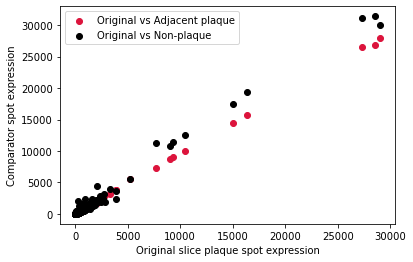

In [174]:
plt.scatter(np.mean(old_m, axis=0),np.mean(new_m, axis=0), c='crimson', label = 'Original vs Adjacent plaque')
plt.scatter(np.mean(old_m, axis=0),np.mean(no_m, axis=0), c='k', label = 'Original vs Non-plaque')
plt.xlabel('Original slice plaque spot expression')
plt.ylabel('Comparator spot expression')
plt.legend()
plt.show()

In [321]:
## Filter by non-overlapping spots
og_filt = og_gene_df.loc[(og_df['plaque'] == 1).values]
new_filt = gene_df.loc[(spot_df['plaque'] == 1).values]
no_filt = gene_df.loc[(spot_df['plaque'] == 0).values]
og_filt

,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Rb1cc1,St18,Pcmtd1,...,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,CAAA01118383.1,Vamp7,Spry3,Tmlhe,AC149090.1
AAAGACCCAAGTCGCG-1,0.0,66.577896,0.000000,199.733688,0.000000,0.000000,0.0,66.577896,0.0,66.577896,...,532.623169,8788.282227,1464.713745,133.155792,14580.559570,0.000000,66.577896,66.577896,0.0,266.311584
AACACGACTGTACTGA-1,0.0,74.537865,74.537865,0.000000,0.000000,0.000000,0.0,74.537865,0.0,0.000000,...,447.227173,17814.548828,2012.522339,74.537865,23703.041016,74.537865,0.000000,0.000000,0.0,149.075729
AACCGAGCTTGGTCAT-1,0.0,0.000000,0.000000,0.000000,0.000000,283.559235,0.0,170.135529,0.0,56.711845,...,283.559235,10378.267578,1587.931641,56.711845,16106.164062,0.000000,56.711845,56.711845,0.0,226.847382
AACCGTTGTGTTTGCT-1,0.0,0.000000,81.294205,0.000000,0.000000,162.588409,0.0,0.000000,0.0,0.000000,...,243.882614,7153.890137,975.530457,0.000000,12681.895508,0.000000,0.000000,0.000000,0.0,0.000000
AACTGATATTAGGCCT-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,192.752502,0.0,64.250832,...,257.003326,13364.172852,1991.775757,0.000000,16319.710938,0.000000,64.250832,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTAATCAGTACGTCAG-1,0.0,63.799919,63.799919,63.799919,127.599838,127.599838,0.0,127.599838,0.0,0.000000,...,255.199677,10016.586914,1594.997925,191.399750,15120.581055,0.000000,63.799919,0.000000,0.0,382.799500
TTCATGGCGCAACAGG-1,0.0,104.047455,34.682484,69.364967,0.000000,208.094910,0.0,0.000000,0.0,173.412415,...,485.554779,14115.770508,1907.536621,34.682484,18208.304688,0.000000,0.000000,0.000000,0.0,277.459869
TTCGGTACTGTAGAGG-1,0.0,0.000000,0.000000,0.000000,0.000000,469.836487,0.0,0.000000,0.0,93.967300,...,375.869202,14283.029297,1597.444092,0.000000,16914.113281,0.000000,93.967300,0.000000,0.0,93.967300
TTGGGAAGACGAGCCG-1,0.0,242.522232,242.522232,161.681488,80.840744,161.681488,0.0,161.681488,0.0,80.840744,...,404.203735,18270.007812,2344.381592,161.681488,21665.320312,0.000000,0.000000,0.000000,0.0,242.522232


In [356]:
cort_l

('Cortex Layer 2/3', 'Cortex Layer 4', 'Cortex Layer 5/6a', 'Cortex Layer 6')

In [392]:
#filter plaques and cortex only
cort_i = []
for i in cort_l:
    cort_i = np.append(cort_i, np.where(spot_df['anot']==i))

og_plq = np.intersect1d(np.where(og_df['plaque']==1)[0], cort_i)
new_plq = np.intersect1d(np.where(spot_df['plaque']==1)[0], cort_i)
no_plq = np.intersect1d(np.where(spot_df['plaque']==0)[0], cort_i)

shared = np.intersect1d(og_plq, new_plq)
og_notin = np.setxor1d(og_plq, shared)
new_notin = np.setxor1d(new_plq, shared)


In [393]:
og_v = np.asarray(og_gene_df.iloc[og_notin])
new_v = np.asarray(gene_df.iloc[new_notin])
no_v = np.asarray(gene_df.iloc[no_plq])
no_v.shape, og_v.shape, new_v.shape

((945, 12404), (69, 12404), (71, 12404))

In [394]:
# perform PCA on og_v
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
og_sc = scaler.fit_transform(og_v)
new_sc = scaler.fit_transform(new_v)
no_sc = scaler.fit_transform(no_v)

pca = PCA(n_components=3)
pca.fit(no_sc)
og_pca = pca.transform(og_sc)
new_pca = pca.transform(new_sc)
no_pca = pca.transform(no_sc)

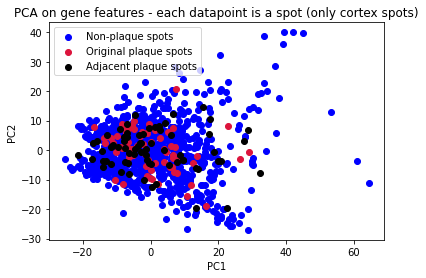

In [562]:
plt.title('PCA on gene features - each datapoint is a spot (only cortex spots)')
plt.scatter(no_pca[:,0], no_pca[:,1], c='b', label = 'Non-plaque spots')
plt.scatter(og_pca[:,0], og_pca[:,1], c='crimson', label = 'Original plaque spots')
plt.scatter(new_pca[:,0], new_pca[:,1], c='k', label = 'Adjacent plaque spots')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig(s_fig + 'plaque-pca.svg', transparent=True)
plt.show()

In [402]:
no_v.shape, og_v.shape, new_v.shape

((945, 12404), (69, 12404), (71, 12404))

In [400]:
# Calculate correlations across plaque spots
plaq_c = np.corrcoef(og_v, new_v)[:new_v.shape[0],new_v.shape[0]:]
plaq_ = np.ravel(plaq_c)
print(plaq_c.shape)

# Calculate correlations plaque - no plaque spots
noplaq_c = np.corrcoef(no_v, new_v)[:new_v.shape[0],new_v.shape[0]:]
noplaq_ = np.ravel(noplaq_c)
print(noplaq_c.shape)

(71, 69)
(71, 945)


In [403]:
np.mean(plaq_), np.mean(noplaq_)

(0.9472961594243551, 0.9411425100557002)

In [564]:
df=pd.DataFrame()
df['correlation'] = np.append(plaq_, noplaq_)
df['plaque'] = np.append(np.full(len(plaq_), 1), np.full(len(noplaq_), 0))
df

,correlation,plaque
0,0.951684,1
1,0.971555,1
2,0.961224,1
3,0.972828,1
4,0.874705,1
...,...,...
71989,0.967256,0
71990,0.959363,0
71991,0.932952,0
71992,0.971607,0


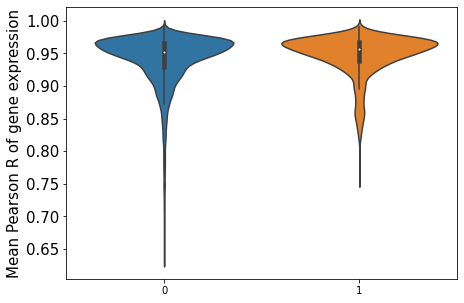

In [570]:
fig,ax = plt.subplots(figsize=(7,5))
sns.violinplot(data=df, x="plaque", y="correlation", jitter=0.2, alpha=0.5)
#
ax.set(xlabel=None)
#plt.xticks([0,1], ['Adjacent plaque - Non-plaque spots', 'Adjacent - Original plaque spots'], fontsize=15)
#plt.xticks(rotation=90)
plt.yticks(fontsize=15)
plt.ylabel('Mean Pearson R of gene expression', fontsize=15)
plt.savefig(s_fig + 'plaque-correlation.svg', transparent=True)
plt.show()

In [421]:
## COMPARE DE GENES
#filter plaques and cortex only
cort_i = []
for i in cort_l:
    cort_i = np.append(cort_i, np.where(spot_df['anot']==i))

og_plq = np.intersect1d(np.where(og_df['plaque']==1)[0], cort_i)
no_plq_og = np.intersect1d(np.where(og_df['plaque']==0)[0], cort_i)

new_plq = np.intersect1d(np.where(spot_df['plaque']==1)[0], cort_i)
no_plq_new = np.intersect1d(np.where(spot_df['plaque']==0)[0], cort_i)

plq_og_v = np.asarray(og_gene_df.iloc[og_plq])
no_og_v = np.asarray(og_gene_df.iloc[no_plq_og])

plq_new_v = np.asarray(gene_df.iloc[new_plq])
no_new_v = np.asarray(gene_df.iloc[no_plq_new])

plq_og_v.shape, no_og_v.shape, plq_new_v.shape, no_new_v.shape

((90, 12404), (947, 12404), (92, 12404), (945, 12404))

In [425]:
name_i = gene_df.columns.values
name_i.shape

(12404,)

In [594]:
# Find DE genes in original section
data1,data2=plq_og_v, no_og_v

import scipy
# Wilcoxon signed rank test
mwu = ([scipy.stats.mannwhitneyu(data1[:,i], data2[:,i], alternative='two-sided') for i in range(data1.shape[1])])
p_vals = np.vstack(mwu)[:,1]
# # sig_ = p_vals < 0.05/gene_m.shape[1]
sig_v, adj_p_vals = mne.stats.fdr_correction(p_vals, 0.05, 'indep') #Use Benjamini hochberg FDR test 
sig_genes = name_i[sig_v]


In [603]:
np.intersect1d(sig_genes, new_sig_genes)

array(['B2m', 'C1qa', 'C4b', 'Ctsd', 'Ctss', 'Gfap', 'H2-Aa', 'H2-D1',
       'Ifi27l2a', 'Lgals3bp', 'Ly6h', 'Ncdn', 'Serpina3n', 'Tyrobp'],
      dtype=object)

In [601]:
np.sort(sig_genes)

array(['Atp2b4', 'B2m', 'C1qa', 'C4b', 'Cabp7', 'Ccl12', 'Cox6a1', 'Ctsd',
       'Ctss', 'Flt3l', 'Fth1', 'Gfap', 'H2-Aa', 'H2-D1', 'H2-K1',
       'Hist1h1c', 'Ifi27l2a', 'Lair1', 'Lgals3bp', 'Ly6e', 'Ly6h',
       'Mapk1', 'Meg3', 'Mfge8', 'Mmp17', 'Ncdn', 'Nmnat2', 'Pcp4',
       'Prss23', 'Rapgef4', 'Serpina3n', 'Spred2', 'Thra', 'Trbc2',
       'Tspan7', 'Tyrobp'], dtype=object)

In [602]:
np.sort(new_sig_genes)

array(['Anxa3', 'Asb2', 'B2m', 'Bst2', 'C1qa', 'C1qb', 'C1qc', 'C4b',
       'Ccl5', 'Cd44', 'Cd52', 'Cd68', 'Cd74', 'Cd84', 'Cela1', 'Chl1',
       'Cmtm6', 'Coa5', 'Csf3r', 'Cst7', 'Ctsb', 'Ctsd', 'Ctsl', 'Ctss',
       'Cxcl16', 'Dhrs1', 'Efna5', 'Fcer1g', 'Fcrls', 'Ftl1', 'Fxyd1',
       'Gfap', 'Gpcpd1', 'Gpr34', 'H2-Aa', 'H2-Ab1', 'H2-D1', 'Hexb',
       'Ifi27', 'Ifi27l2a', 'Ifit3', 'Ifitm3', 'Irgm1', 'Isg15', 'Klk6',
       'Lgals3bp', 'Ly6h', 'Ly86', 'Lyz2', 'Mpeg1', 'Ncdn', 'Ncf2',
       'Nek6', 'Olfml3', 'Pole3', 'Ppip5k2', 'Ptpn6', 'Pycard', 'S100a6',
       'Serpina3n', 'Sparc', 'Tagln2', 'Tnfaip8l2', 'Trem2', 'Tyrobp',
       'Vim', 'Zfp809'], dtype=object)

In [596]:
#Volcano plot
lgf2 = np.asarray([np.log2(np.mean(data1[:,i])/np.mean(data2[:,i])) for i in range(data1.shape[1])])
value1 = np.asarray([np.mean(data1[:,i]) for i in range(data1.shape[1])])
value2 = np.asarray([np.mean(data2[:,i]) for i in range(data2.shape[1])])
df = {'GeneNames': np.array(name_i), 'plaque': value1, 'no plaque':value2, 'log2FC': lgf2, 'p-value': adj_p_vals}
df = pd.DataFrame(df)

#Find top n DE genes
sorted = np.sort(adj_p_vals)[:10]
top_n = [df['GeneNames'].iloc[np.where(adj_p_vals == i)[0][0]] for i in sorted]
df


<ipython-input-596-cf7c8e993681>:2: RuntimeWarning: divide by zero encountered in log2
  lgf2 = np.asarray([np.log2(np.mean(data1[:,i])/np.mean(data2[:,i])) for i in range(data1.shape[1])])


,GeneNames,plaque,no plaque,log2FC,p-value
0,Sox17,9.626844,4.985401,0.949354,0.621706
1,Mrpl15,40.853493,51.272083,-0.327714,0.756761
2,Lypla1,34.528564,39.779110,-0.204221,0.766850
3,Tcea1,74.593124,74.728897,-0.002624,0.903044
4,Rgs20,36.618835,34.037273,0.105470,0.942611
...,...,...,...,...,...
12399,CAAA01118383.1,8.049618,8.058754,-0.001636,0.906167
12400,Vamp7,43.984745,37.730717,0.221264,0.808954
12401,Spry3,6.129004,7.231562,-0.238655,0.919539
12402,Tmlhe,4.115935,3.195363,0.365240,0.863636


In [538]:
top_n

['H2-D1',
 'B2m',
 'Gfap',
 'Lgals3bp',
 'Ly6e',
 'Ifi27l2a',
 'Ifi27l2a',
 'Ctss',
 'Pcp4',
 'Cox6a1']

In [597]:
#from bioinfokit import analys, visuz
# load dataset as pandas dataframe
visuz.GeneExpression.volcano(df=df, dim = (10,8), color = ('red', 'grey', 'green') , lfc='log2FC', pv='p-value', 
                            gstyle=1, geneid = 'GeneNames', lfc_thr=(0.5,0.5), valpha = 0.8, 
                            genenames = tuple(top_n), sign_line=True
                             ,plotlegend=True, legendpos='upper left',
                             axtickfontsize = 25, axtickfontname='sans',axlabelfontsize=25, dotsize = 25, gfont=15, figtype='png')
    
                            

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/colors.py:1310: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/ticker.py:536: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [598]:
# Find DE genes in original section
data1,data2=plq_new_v, no_new_v

import scipy
# Wilcoxon signed rank test
mwu = ([scipy.stats.mannwhitneyu(data1[:,i], data2[:,i], alternative='two-sided') for i in range(data1.shape[1])])
p_vals = np.vstack(mwu)[:,1]
# # sig_ = p_vals < 0.05/gene_m.shape[1]
sig_v, adj_p_vals = mne.stats.fdr_correction(p_vals, 0.05, 'indep') #Use Benjamini hochberg FDR test 
new_sig_genes = name_i[sig_v]


In [591]:
#Volcano plot
lgf2 = np.asarray([np.log2(np.mean(data1[:,i])/np.mean(data2[:,i])) for i in range(data1.shape[1])])
value1 = np.asarray([np.mean(data1[:,i]) for i in range(data1.shape[1])])
value2 = np.asarray([np.mean(data2[:,i]) for i in range(data2.shape[1])])
df = {'GeneNames': np.array(name_i), 'plaque': value1, 'no plaque':value2, 'log2FC': lgf2, 'p-value': adj_p_vals}
df = pd.DataFrame(df)

#Find top n DE genes
sorted = np.sort(adj_p_vals)[:10]
top_n = [df['GeneNames'].iloc[np.where(adj_p_vals == i)[0][0]] for i in sorted]
df


<ipython-input-591-cf7c8e993681>:2: RuntimeWarning: divide by zero encountered in log2
  lgf2 = np.asarray([np.log2(np.mean(data1[:,i])/np.mean(data2[:,i])) for i in range(data1.shape[1])])


,GeneNames,plaque,no plaque,log2FC,p-value
0,Sox17,4.711431,5.454115,-0.211180,0.983591
1,Mrpl15,51.871559,50.221474,0.046639,0.995621
2,Lypla1,46.373020,38.637112,0.263298,0.907690
3,Tcea1,62.580536,75.898659,-0.278360,0.700067
4,Rgs20,38.617672,33.837215,0.190650,0.948626
...,...,...,...,...,...
12399,CAAA01118383.1,6.352973,8.223949,-0.372400,0.919022
12400,Vamp7,37.901993,38.309662,-0.015435,0.985376
12401,Spry3,5.804730,7.265466,-0.323826,0.904473
12402,Tmlhe,2.097820,3.389888,-0.692347,0.912611


In [593]:
#from bioinfokit import analys, visuz
# load dataset as pandas dataframe
visuz.GeneExpression.volcano(df=df, dim = (10,8), color = ('red', 'grey', 'green') , lfc='log2FC', pv='p-value', 
                            gstyle=1, geneid = 'GeneNames', lfc_thr=(0.5,0.5), valpha = 0.8, 
                            genenames = tuple(top_n), sign_line=True
                             ,plotlegend=True, legendpos='upper left',
                             axtickfontsize = 25, axtickfontname='sans',axlabelfontsize=25, dotsize = 25, gfont=15, figtype='png')
    
                            

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/colors.py:1310: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/ticker.py:536: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [547]:
np.sort(np.intersect1d(new_sig_genes, sig_genes))

array(['B2m', 'C1qa', 'C4b', 'Ctsd', 'Ctss', 'Gfap', 'H2-Aa', 'H2-D1',
       'Ifi27l2a', 'Lgals3bp', 'Ly6h', 'Ncdn', 'Serpina3n', 'Tyrobp'],
      dtype=object)

# Correlate APP expression with plaque levels

In [15]:
np.append(gene_all, gene_df['humanAPP'].values)

array([594.2948 , 953.113  , 198.62947, ..., 135.54422, 216.73952,
       229.06883], dtype=float32)

In [16]:
#group data together
name_l = '030-B', '030-C', '040-A', '040-C', '040-D'

for name in name_l:
    spot_df, gene_df = run_(name)
    if name == name_l[0]: 
        gene_all = gene_df['humanAPP'].values
        lab = spot_df['plaque']
        name_all = np.repeat(name, len(gene_df['humanAPP'].values))
    else: 
        gene_all = np.append(gene_all, gene_df['humanAPP'].values)
        lab = np.hstack((lab, spot_df['plaque']))
        name_all = np.hstack((name_all, np.repeat(name, len(gene_df['humanAPP'].values))))

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2939
Number of genes: 32285


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3532
Number of genes: 32285


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3465
Number of genes: 32285


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3616
Number of genes: 32285


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3457
Number of genes: 32285


In [68]:
df = pd.DataFrame({'human APP CPMs': gene_all, 'plaque': lab, 'sample': name_all})
df

,human APP CPMs,plaque,sample
0,594.294800,0,030-B
1,953.112976,0,030-B
2,198.629471,0,030-B
3,285.861298,0,030-B
4,195.121948,0,030-B
...,...,...,...
17004,366.193054,0,040-D
17005,429.397186,0,040-D
17006,365.020599,0,040-D
17007,730.239502,0,040-D


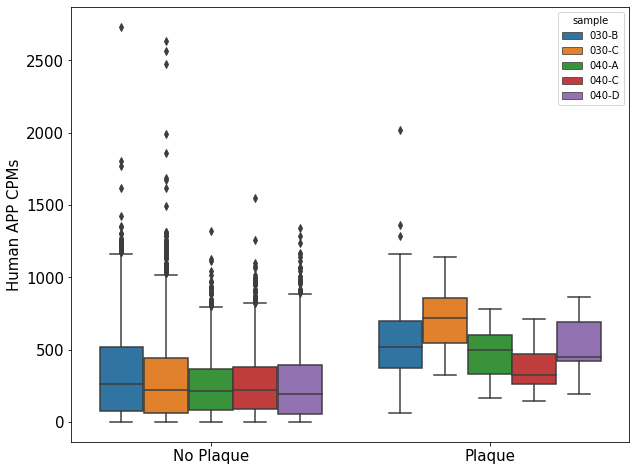

In [78]:
import seaborn as sns
# Correlate human APP expression with plaque load -- treat each spot independently
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x = 'plaque', y ='human APP CPMs', hue = 'sample')
#set label names and size
ax.set_ylabel('Human APP CPMs', fontsize=15)
#remove x label
ax.set_xlabel('')
#change x tick names
ax.set_xticklabels(['No Plaque', 'Plaque'], fontsize=15)
#increase y tick size
ax.tick_params(axis='y', labelsize=15)
plt.show()

In [86]:
i=0
df['human APP CPMs'].iloc[np.where((df['plaque'] == 0) & (df['sample'] == name_l[i]))[0]].values

array([594.2948 , 953.113  , 198.62947, ..., 937.20715, 201.57227,
         0.     ], dtype=float32)

In [89]:
# significant test
from scipy.stats import mannwhitneyu
# Wilcoxon signed rank test
for i in range(len(name_l)):
    print(mannwhitneyu(df['human APP CPMs'].iloc[np.where((df['plaque'] == 0) & (df['sample'] == name_l[i]))[0]].values, df['human APP CPMs'].iloc[np.where((df['plaque'] == 1) & (df['sample'] == name_l[i]))[0]].values, alternative='two-sided'))

MannwhitneyuResult(statistic=77535.0, pvalue=1.1736246740466518e-15)
MannwhitneyuResult(statistic=4786.0, pvalue=1.4367573145619633e-05)
MannwhitneyuResult(statistic=8506.0, pvalue=0.0004035117312429103)
MannwhitneyuResult(statistic=41053.0, pvalue=6.613302926617175e-05)
MannwhitneyuResult(statistic=9409.0, pvalue=4.89089698665726e-06)


In [105]:
from scipy.stats import pointbiserialr

pointbiserialr(df['plaque'], df['human APP CPMs'])

SignificanceResult(statistic=0.1044420687279617, pvalue=1.8201273802524843e-42)

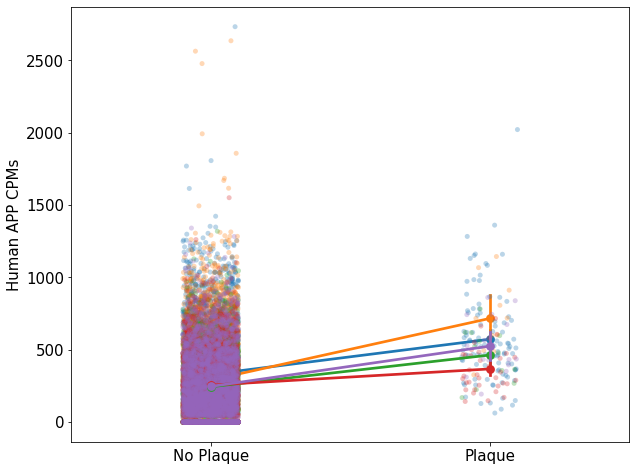

In [102]:
import seaborn as sns
# Correlate human APP expression with plaque load -- treat each spot independently
fig,ax = plt.subplots(figsize=(10,8))
sns.stripplot(data=df, x = 'plaque', y ='human APP CPMs', hue = 'sample', alpha=0.3)
sns.pointplot(data=df, x = 'plaque', y ='human APP CPMs', hue = 'sample', label=None)#, ci=None, color='grey')

#set label names and size
ax.set_ylabel('Human APP CPMs', fontsize=15)
#remove x label
ax.set_xlabel('')
#change x tick names
ax.set_xticklabels(['No Plaque', 'Plaque'], fontsize=15)
#increase y tick size
ax.tick_params(axis='y', labelsize=15)
#remove legend
ax.legend_.remove()
plt.show()

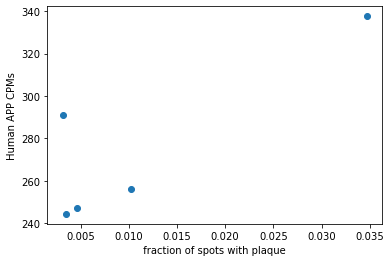

In [52]:
plt.scatter(plq_pc, curr_exp)
#set x and y axis labels
plt.xlabel(' fraction of spots with plaque ')
plt.ylabel('Human APP CPMs')
plt.show()

In [40]:
curr_exp, sum_plq

(247.18889, 16)

In [ ]:
# Correlate human APP expression with plaque load -- mean for each sample


# Plaque differential expression


In [5]:
#sort out names
import glob
import os
os.chdir('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/coords/')
og = glob.glob('*.json')
ID = [i.split('.')[0] for i in og]
sub_ID=[]
for x,i in enumerate(og):
    if x != 6: sub_ID = np.append(sub_ID, i.split('_')[1][:-5])
    else: sub_ID = np.append(sub_ID, i[:-5])
ID, sub_ID


(['V10S15_040-D',
  'V11Y17_109-C',
  'S29_030-D',
  'V10S15_040-A',
  'V11Y17_109-A',
  'V10S15_040-C',
  '030-B',
  'V11Y10_030-C',
  'V11Y17_109-D'],
 array(['040-D', '109-C', '030-D', '040-A', '109-A', '040-C', '030-B',
        '030-C', '109-D'], dtype='<U32'))

In [6]:
#Load in metadata
meta = pd.read_csv('/cndd2/agelber/hal/metadata.csv')
meta

,sample,age,sex,genotype,time,sample_number,sample_name,resequenced
0,039-A_S18,7 months,F,WT,ZT0,S18,039-A,False
1,039-B_S19,7 months,F,WT,ZT6,S19,039-B,True
2,039-C_S20,7 months,F,WT,ZT12,S20,039-C,True
3,039-D_S21,7 months,F,WT,ZT18,S21,039-D,False
4,042-A_S22,7 months,M,WT,ZT6,S22,042-A,False
...,...,...,...,...,...,...,...,...
61,351-D_S12,14 months,F,WT,ZT18,S12,351-D,False
62,043-A_S12,14 months,F,APP23,ZT0,S12,043-A,True
63,043-B_S13,14 months,M,APP23,ZT6,S13,043-B,True
64,043-C_S14,14 months,F,WT,ZT12,S14,043-C,True


In [ ]:
def adj(spot_df):
    plq_bool = spot_df['plaque'].values == 1
    all_coords = spot_df['pxl_row_in_fullres'].values, spot_df['pxl_col_in_fullres'].values

    #find the n nearest neighbours
    from sklearn.neighbors import NearestNeighbors
    X = np.asarray(all_coords).T
    nbrs = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)

    adj_ind = np.unique(np.ravel(indices[plq_bool][:,1:])) #indeces nn of plq spots
    final_adjind = np.intersect1d(adj_ind,np.setxor1d(adj_ind, indices[plq_bool][:,0])) #check that adj spots that are not plaques
    return(final_adjind)


In [12]:
#group data together for DESEQ
# Plaque vs no plaque
name_l = ID
drop = [] #genes with < 10 counts in a single sample to drop

#Pull out sex and time for each sample
sex_l = [meta['sex'][meta['sample_name'] == i].values[0] for i in sub_ID]

for x,name in enumerate(name_l):
    spot_df, gene_df = run_(ID[x], sub_ID[x])
    sample = np.full(len(spot_df), sub_ID[x])
    sex = np.full(len(spot_df), sex_l[x])
    spot_df['sample'] = sample
    spot_df['sex'] = sex
    spot_df['adj'] = np.zeros(len(spot_df))
    adj_ind = adj(spot_df)
    spot_df['adj'].iloc[adj_ind] = 1

    new_df = spot_df[['barcode', 'sample', 'sex', 'plaque', 'adj', 'cluster', 'array_row', 'array_col']]
    new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
    gene_df.index = gene_df.index.astype(str)+'_'+new_df['sample'].astype(str)
    drop = np.append(drop, gene_df.T[np.sum(gene_df, axis=0) < 10].index.values)
    if name == name_l[0]: 
        gene_all = gene_df
        lab = new_df
    else: 
        gene_all = pd.concat([gene_all, gene_df], axis=0)
        lab = pd.concat([lab, new_df], axis=0)

gene_all = gene_all.T #genes x rows needed for DESEQ
gene_all.drop(np.unique(drop), axis=0, inplace=True)
lab = lab.set_index('barcode')
lab['adj'] = lab['adj'].values.astype(int)   

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3285
Number of genes: 32284


NameError: name 'adj' is not defined

In [94]:
gene_all

,AAACAAGTATCTCCCA-1_109-D,AAACAGAGCGACTCCT-1_109-D,AAACAGCTTTCAGAAG-1_109-D,AAACATTTCCCGGATT-1_109-D,AAACCCGAACGAAATC-1_109-D,AAACCGTTCGTCCAGG-1_109-D,AAACCTAAGCAGCCGG-1_109-D,AAACGAAGAACATACC-1_109-D,AAACGAGACGGTTGAT-1_109-D,AAACGCCCGAGATCGG-1_109-D,...,TTGTGTATGCCACCAA-1_040-D,TTGTGTTTCCCGAAAG-1_040-D,TTGTTAGCAAATTCGA-1_040-D,TTGTTCAGTGTGCTAC-1_040-D,TTGTTGTGTGTCAAGA-1_040-D,TTGTTTCACATCCAGG-1_040-D,TTGTTTCATTAGTCTA-1_040-D,TTGTTTCCATACAACT-1_040-D,TTGTTTGTATTACACG-1_040-D,TTGTTTGTGTAAATTC-1_040-D
Xkr4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm19938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sox17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mrpl15,0.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
Lypla1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vamp7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,2.0,0.0,1.0,0.0,1.0,2.0,3.0,2.0,0.0
Spry3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tmlhe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAAA01147332.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
lab

,sample,sex,plaque,adj,cluster,pxl_row_in_fullres,pxl_col_in_fullres
barcode,,,,,,,
AAACAAGTATCTCCCA-1_109-D,109-D,M,0,1,Cortex Layer 4,403,1523
AAACAGAGCGACTCCT-1_109-D,109-D,M,0,0,Fiber Tracts,492,846
AAACAGCTTTCAGAAG-1_109-D,109-D,M,0,0,Piriform Cortex,1410,1395
AAACATTTCCCGGATT-1_109-D,109-D,M,0,1,Cortex Layer 2/3,456,1731
AAACCCGAACGAAATC-1_109-D,109-D,M,0,0,Cortex Layer 2/3,263,1429
...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1_040-D,040-D,F,0,0,Cortex Layer 6a,1048,1875
TTGTTTCATTAGTCTA-1_040-D,040-D,F,0,0,Cortex Layer 5a,1175,1912
TTGTTTCCATACAACT-1_040-D,040-D,F,0,1,Cortex Layer 2/3,1207,1636


In [7]:
#load in plaque DE genes
plq_de = pd.read_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/DESEQ/old-app-cortex-plaque_DESEQ-pval.csv', index_col=0)
#plq_de_reg = pd.read_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/DESEQ/old-app-cortex-p-region_DESEQ-pval.csv', index_col=0)
adj_de = pd.read_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/DESEQ/old-app-cortex-adj_DESEQ-pval.csv', index_col=0)

plq_de = plq_de
#replace all nans with 1
plq_de['padj'][np.isnan(plq_de['padj'])] = 1
#add name GeneNames to index of plq_de
#put geneid at first column 
plq_de['geneid'] = plq_de.index
plq_de = plq_de[['geneid', 'padj', 'log2FoldChange', 'baseMean', 'lfcSE', 'stat', 'pvalue']]
plq_de

,geneid,padj,log2FoldChange,baseMean,lfcSE,stat,pvalue
Ctsz,Ctsz,0.007691,0.489762,175.904233,0.098983,4.947941,7.500262e-07
H2-D1,H2-D1,0.014956,0.562289,178.020618,0.121150,4.641247,3.463128e-06
Ly86,Ly86,0.014956,0.823994,70.096807,0.179414,4.592697,4.375542e-06
B2m,B2m,0.016527,0.453402,672.686993,0.100506,4.511172,6.447041e-06
Serpina3n,Serpina3n,0.040789,1.238938,71.682376,0.292290,4.238729,2.247891e-05
...,...,...,...,...,...,...,...
Pdpk1,Pdpk1,0.999991,-0.000040,188.754895,0.097982,-0.000413,9.996707e-01
Mrpl37,Mrpl37,0.999991,-0.000016,72.129944,0.137385,-0.000117,9.999066e-01
Hnrnpa1,Hnrnpa1,0.999991,-0.000008,369.573173,0.069085,-0.000113,9.999097e-01
Cnot4,Cnot4,0.999991,-0.000011,35.059424,0.231332,-0.000049,9.999609e-01


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

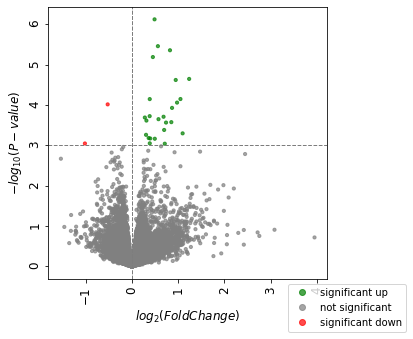

In [9]:

from bioinfokit import analys, visuz
# load dataset as pandas dataframe
visuz.GeneExpression.volcano(df=plq_de, lfc='log2FoldChange', pv='pvalue', dim = (5,5), dotsize=10, geneid = 'geneid', genenames = tuple(plq_de[plq_de['padj'] < 0.1]['geneid'].values)[20:30] , valpha = 0.7,gstyle=1, sign_line=True
                             ,show=True,plotlegend=True, legendpos='upper right',legendanchor=(1.30,0), pv_thr = (0.001,0.001), lfc_thr=(0,0), axtickfontsize=12, axlabelfontsize=12, gfont=10, figtype='png')
                            

# Plaque environment

In [4]:
#Calculate distance of each spot to nearest plaque, and save as metadata
#OLD ANIMALS
#sort out names
import glob
import os
age = 'old'
os.chdir('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/coords/' + age)
og = glob.glob('*.json')
ID = [i.split('.')[0] for i in og]
sub_ID=[]
for x,i in enumerate(og):
    if x != 1: sub_ID = np.append(sub_ID, i.split('_')[1][:-5])
    else: sub_ID = np.append(sub_ID, i[:-5])
ID, sub_ID

(['V11Y10_030-C',
  '030-B',
  'V11Y17_109-D',
  'V11Y17_109-A',
  'V10S15_040-C',
  'V11Y17_109-C',
  'S29_030-D',
  'V10S15_040-A',
  'V10S15_040-D'],
 array(['030-C', '030-B', '109-D', '109-A', '040-C', '109-C', '030-D',
        '040-A', '040-D'], dtype='<U32'))

In [32]:
#Calculate distance of each spot to nearest plaque, and save as metadata
#=======================================================================
name_l = ID
age='old'
#Pull out sex and time for each sample
sex_l = [meta['sex'][meta['sample_name'] == i].values[0] for i in sub_ID]

for x,name in enumerate(name_l):
    #Create metadata for each sample
    spot_df, gene_df = run_(age,ID[x], sub_ID[x])
    sample = np.full(len(spot_df), sub_ID[x])
    sex = np.full(len(spot_df), sex_l[x])
    spot_df['sample'] = sample
    spot_df['sex'] = sex

    new_df = spot_df[['barcode', 'sample', 'sex', 'plaque', 'cluster', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres']]
    new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
    new_df = pf.dist_nearest_plaq(new_df)
    #save to csv
    new_df.to_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/metadata/' + age + '/' + sub_ID[x] + '.csv')

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3397
Number of genes: 32284


<ipython-input-32-b50a8c85133f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2835
Number of genes: 32284


<ipython-input-32-b50a8c85133f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2959
Number of genes: 32284


<ipython-input-32-b50a8c85133f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3204
Number of genes: 32284


<ipython-input-32-b50a8c85133f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3406
Number of genes: 32284


<ipython-input-32-b50a8c85133f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3002
Number of genes: 32284


<ipython-input-32-b50a8c85133f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2998
Number of genes: 32284


<ipython-input-32-b50a8c85133f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3343
Number of genes: 32284


<ipython-input-32-b50a8c85133f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3285
Number of genes: 32284


<ipython-input-32-b50a8c85133f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)


### Gene expression as a function of plaque distance

In [6]:
#Calculate distance of each spot to nearest plaque, and save as metadata
#OLD ANIMALS
#sort out names
import glob
import os
age = 'old'
os.chdir('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/coords/' + age)
og = glob.glob('*.json')
ID = [i.split('.')[0] for i in og]
sub_ID=[]
for x,i in enumerate(og):
    if x != 1: sub_ID = np.append(sub_ID, i.split('_')[1][:-5])
    else: sub_ID = np.append(sub_ID, i[:-5])
ID, sub_ID

(['V11Y10_030-C',
  '030-B',
  'V11Y17_109-D',
  'V11Y17_109-A',
  'V10S15_040-C',
  'V11Y17_109-C',
  'S29_030-D',
  'V10S15_040-A',
  'V10S15_040-D'],
 array(['030-C', '030-B', '109-D', '109-A', '040-C', '109-C', '030-D',
        '040-A', '040-D'], dtype='<U32'))

In [13]:
df = pd.read_csv('/cndd/dburrows/DATA/te/rna/PE.counts/DESEQ/ATEM_Count.csv', index_col=0)
df

,1105-GABA,1105-GLU,1133-GABA,1133-GLU,1134-GABA,1134-GLU,1275-GABA,1275-GLU,1277-GABA,1277-GLU,...,Hct16HCQA020-GABA,Hct16HCQA020-GLU,Hct16HECA028-GABA,Hct16HECA028-GLU,Hct17HEIA010-GABA,Hct17HEIA010-GLU,HctYPA008-GABA,HctYPA008-GLU,HctZZNA014-GABA,HctZZNA014-GLU
element,,,,,,,,,,,,,,,,,,,,,
L1PA3,1714,1504,2863,2466,1935,1759,2162,1452,1692,1885,...,2344,2148,1842,1699,2553,1973,2614,2706,2480,2362
L1PA5,1812,1383,2737,2308,2016,1703,2149,1138,1753,1758,...,2503,2279,1836,1798,2522,1784,2818,2783,2617,2220
L1HS,1278,915,3020,2567,1464,1613,2185,1304,1475,1993,...,2063,1785,1617,1842,1607,1508,1597,1979,2062,2403
L1PA6,837,784,1330,1517,925,986,1106,573,775,899,...,1082,1055,916,1044,1129,1118,1233,1414,1135,1193
L1PA7,1400,1191,2353,2023,1581,1394,2108,1210,1419,1419,...,1814,1370,1702,1498,1892,1518,1891,1994,1802,1588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AluYk12,228,184,443,290,220,194,128,97,151,327,...,211,234,152,142,301,174,113,171,224,160
FLAM_C,636,466,768,576,450,441,656,507,626,530,...,749,547,553,481,680,471,868,730,865,529
MIR1_Amn,934,727,1035,894,865,772,820,756,740,690,...,711,551,658,648,853,665,633,721,838,735


In [10]:
dm = pd.read_csv('/cndd/dburrows/DATA/te/rna/PE.counts/DESEQ/ATEM_design.csv', index_col=0)
dm

,Cell Type,sex,race,AGEYEARS
1105-GABA,GABA,Male,White,-0.491468
1105-GLU,GLU,Male,White,-0.491468
1133-GABA,GABA,Male,White,0.480801
1133-GLU,GLU,Male,White,0.480801
1134-GABA,GABA,Male,White,0.613383
...,...,...,...,...
Hct17HEIA010-GLU,GLU,Female,White,-1.065991
HctYPA008-GABA,GABA,Male,White,2.115981
HctYPA008-GLU,GLU,Male,White,2.115981
HctZZNA014-GABA,GABA,Female,White,0.524995


In [74]:
#group data together for DESEQ
# Plaque vs no plaque
name_l = ID
age='old'
drop = [] #genes with < 10 counts in a single sample to drop

#Pull out sex and time for each sample
sex_l = [meta['sex'][meta['sample_name'] == i].values[0] for i in sub_ID]

for x,name in enumerate(name_l):
    name = name_l[x]
    spot_df, gene_df = run_(age, ID[x], sub_ID[x])
    sample = np.full(len(spot_df), sub_ID[x])
    sex = np.full(len(spot_df), sex_l[x])
    spot_df['sample'] = sample
    spot_df['sex'] = sex

    new_df = spot_df[['barcode', 'sample', 'sex', 'plaque', 'cluster', 'pxl_row_in_fullres', 'pxl_col_in_fullres']]
    new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
    gene_df.index = gene_df.index.astype(str)+'_'+new_df['sample'].astype(str)
    drop = np.append(drop, gene_df.T[np.sum(gene_df, axis=0) < 10].index.values)
    ind = [i for i in range(len(new_df)) if 'Cortex L' in new_df['cluster'].iloc[i]]
    new_df = pf.dist_nearest_plaq(new_df)
    new_df = new_df.iloc[ind]
    new_df.drop(['plaque', 'cluster', 'pxl_row_in_fullres', 'pxl_col_in_fullres'], axis=1, inplace=True)
    gene_df  = gene_df.iloc[ind]

    if name == name_l[0]: 
        gene_all = gene_df
        lab = new_df
    else: 
        gene_all = pd.concat([gene_all, gene_df], axis=0)
        lab = pd.concat([lab, new_df], axis=0)

gene_all = gene_all.T #genes x rows needed for DESEQ
gene_all.drop(np.unique(drop), axis=0, inplace=True)
lab = lab.set_index('barcode')

dm = lab
dist_ = dm['dist_nearest_plaq'].values
new_dist = (dist_ - np.mean(dist_))/np.std(dist_)
dm['dist_nearest_plaq'] = new_dist

# make design matrix 
dm.to_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/DESEQ/plaque_environment/old-APP-cortex_plqdist_design.csv')
gene_all.to_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/DESEQ/plaque_environment/old-APP-cortex_plqdist_counts.csv')

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3397
Number of genes: 32284


<ipython-input-74-bad60482bc82>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/cndd3/dburrows/CODE/spatial_transcriptomics/plaque_f.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_nearest_plaq'] = dist_v
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_

Number of spots: 2835
Number of genes: 32284


<ipython-input-74-bad60482bc82>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/cndd3/dburrows/CODE/spatial_transcriptomics/plaque_f.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_nearest_plaq'] = dist_v
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_

Number of spots: 2959
Number of genes: 32284


<ipython-input-74-bad60482bc82>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/cndd3/dburrows/CODE/spatial_transcriptomics/plaque_f.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_nearest_plaq'] = dist_v
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_

Number of spots: 3204
Number of genes: 32284


<ipython-input-74-bad60482bc82>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/cndd3/dburrows/CODE/spatial_transcriptomics/plaque_f.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_nearest_plaq'] = dist_v
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_

Number of spots: 3406
Number of genes: 32284


<ipython-input-74-bad60482bc82>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/cndd3/dburrows/CODE/spatial_transcriptomics/plaque_f.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_nearest_plaq'] = dist_v
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_

Number of spots: 3002
Number of genes: 32284


<ipython-input-74-bad60482bc82>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/cndd3/dburrows/CODE/spatial_transcriptomics/plaque_f.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_nearest_plaq'] = dist_v
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_

Number of spots: 2998
Number of genes: 32284


<ipython-input-74-bad60482bc82>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/cndd3/dburrows/CODE/spatial_transcriptomics/plaque_f.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_nearest_plaq'] = dist_v
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_

Number of spots: 3343
Number of genes: 32284


<ipython-input-74-bad60482bc82>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/cndd3/dburrows/CODE/spatial_transcriptomics/plaque_f.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_nearest_plaq'] = dist_v
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_

Number of spots: 3285
Number of genes: 32284


<ipython-input-74-bad60482bc82>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/cndd3/dburrows/CODE/spatial_transcriptomics/plaque_f.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_nearest_plaq'] = dist_v


In [85]:
# make design matrix 
dm.to_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/DESEQ/plaque_environment/old-APP-cortex_plqdist_design.csv')
gene_all.to_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/DESEQ/plaque_environment/old-APP-cortex_plqdist_counts.csv')

In [10]:
dist_v

array([ 77.79460136, 193.99226789,  21.09502311, 317.90721917,
       208.62646045, 208.3386666 , 184.83506161, 339.18726391,
       113.45483683, 224.        ,  43.9089968 , 334.96566988,
        77.88452991,  21.9544984 , 151.4496616 ,  86.45229899,
         0.        , 318.15719385, 172.90459797,  21.9544984 ,
       322.55232134, 193.99226789, 114.86513831, 313.49800637,
        74.43117626,  86.45229899, 163.00306746,  75.        ,
        64.49806199,  21.9544984 ,   0.        , 141.20906486,
       318.19019469,  74.43117626,  21.9544984 , 131.38112498,
       281.21522007, 240.30189346,  36.7151195 ,  57.24508713,
        22.        , 342.22945519, 227.74766739,  57.48912941,
        78.16009212,   0.        ,  98.68130522, 290.13100489,
         0.        , 219.22819162,  38.        , 323.48724859,
       135.09256086,  43.        ,  75.        ,  94.40338977,
        77.79460136, 353.57884552,  21.47091055,  77.79460136,
       188.00265956, 191.88017094, 337.00148368, 227.69

In [ ]:
norm_gene = pd.DataFrame()
for x,s in enumerate(sub_ID):
    gol = cort_gene.T[cort_lab['sample'] == s].T/np.sum(_gene.values,axis=0)[x]
    norm_gene = pd.concat([norm_gene, gol], axis=1)
    
sort_dist, sort_name =adm.sort_2list(cort_lab['dist'], cort_lab.index.values)
fin_gene = norm_gene[sort_name]


# pearson r and p value 
import scipy.stats as stats
p_, c_ = [], []
for i in range(fin_gene.shape[0]):
    do = stats.pearsonr(sort_dist, fin_gene.values[i])
    p_ = np.append(p_, do[1])
    c_ = np.append(c_, do[0])


import mne
sig_v, adj_p_vals = mne.stats.fdr_correction(p_, 0.01, 'indep') #Use Benjamini hochberg FDR test 

plus_c = c_[c_ > 0]
plus_p = p_[c_ > 0]
plus_g = fin_gene.iloc[c_>0]
plus_adjp_s, plus_adjp_gene_s = adm.sort_2list(plus_p, plus_g.index.values)
swp = plus_adjp_gene_s[:20]


plus_fin = pd.DataFrame()
for s in swp:
    now = plus_g.loc[s]
    plus_fin = pd.concat([plus_fin, now], axis=1)
plus_fin = plus_fin.T


### DAM score as a function of plaque distance

### CSIDE proportions as a function of plaque distance

### Correlate gene expression with plaque number 

In [10]:
#Sum over each sample
cort_ind = ['Cortex L' in lab['cluster'].values[i] for i in range(len(lab['cluster'].values))]
cort_lab = lab[cort_ind]
cort_gene = gene_all.T[cort_ind].T
cort_gene


NameError: name 'lab' is not defined

In [156]:
_gene=pd.DataFrame()
_counts =[]

for s in sub_ID:
    sumd =  np.sum(cort_gene.T[cort_lab['sample'] == s])
    sumd = pd.DataFrame(sumd, columns=[s])
    _gene = pd.concat([_gene, sumd], axis=1)
    _counts = np.append(_counts, sum(cort_lab[cort_lab['sample'] == s]['plaque'].values))


<ipython-input-156-cfb0189b9400>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sumd =  np.sum(cort_gene.T[cort_lab['sample'] == s])
<ipython-input-156-cfb0189b9400>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sumd =  np.sum(cort_gene.T[cort_lab['sample'] == s])
<ipython-input-156-cfb0189b9400>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sumd =  np.sum(cort_gene.T[cort_lab['sample'] == s])
<ipython-input-156-cfb0189b9400>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sumd =  np.sum(cort_gene.T[cort_lab['sample'] == s])
<ipython-input-156-cfb0189b9400>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sumd =  np.sum(cort_gene.T[cort_lab['sample'] == s])
<ipython-input-156-cfb0189b9400>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sumd =  np.sum(cort_gene.T[cort_lab['sample'] == s]

In [ ]:
gene_norm = (_gene.values/np.sum(_gene.values,axis=0))*1000000

In [75]:
sub_ = cort_gene[adj_p_vals<0.2]
sub_gn = gene_norm[adj_p_vals < 0.2]

Index(['Arid5a', 'Neu4', 'Prdx6', 'Fcer1g', 'Nfe2l2', 'Prr5l', 'Decr1',
       'Glipr2', 'Cd52', 'Mmd2', 'Hpgds', 'Capg', 'Cd9', 'Cacng8', 'Lgi4',
       'Siglech', 'Cyba', 'Cmtm6', 'Tgfbr2', 'Ccl9', 'Ccl6', 'Slc16a3', 'Ly86',
       'Gm5086', 'Tspan14', 'Pros1', 'H2-DMb1', 'Slc14a1', 'Kcne1l'],
      dtype='object')

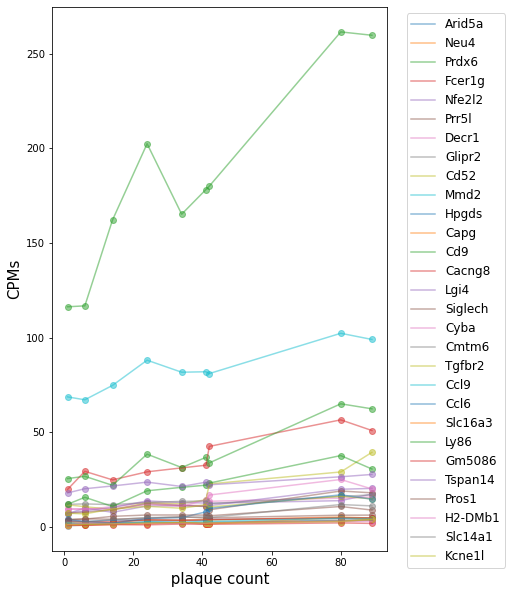

In [88]:
fig,ax = plt.subplots(figsize=(6,10))
for i in range(sub_gn.shape[0]):
    curr = adm.sort_2list(_counts, sub_gn[i])
    plt.plot(curr[0], curr[1], alpha=0.5, label = sub_.index[i]) 
    plt.scatter(_counts, sub_gn[i], alpha=0.5)
#set x and y axis labels
plt.xlabel(' plaque count ', fontsize=15)
plt.ylabel('CPMs', fontsize=15)
plt.legend(fontsize=12,bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig(s_fig + '/plaquenum_CPMs.svg', transparent=True)
plt.show()

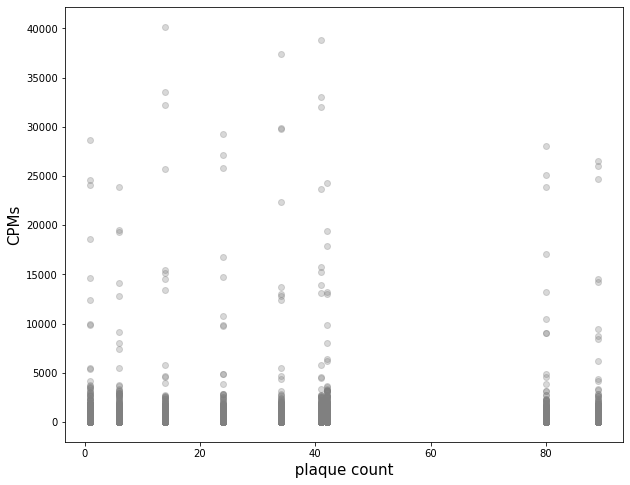

In [37]:
fig,ax = plt.subplots(figsize=(10,8))
for i in range(len(_gene.values)):
    plt.scatter(_counts, gene_norm[i], c='grey', alpha=0.3)
#set x and y axis labels
plt.xlabel(' plaque count ', fontsize=15)
plt.ylabel('CPMs', fontsize=15)
plt.savefig(s_fig + '/plaquenum_CPMs.png', transparent=True)
plt.show()

In [14]:
norm_gene = pd.DataFrame()
for x,s in enumerate(sub_ID):
    gol = cort_gene.T[cort_lab['sample'] == s].T/np.sum(_gene.values,axis=0)[x]
    norm_gene = pd.concat([norm_gene, gol], axis=1)

In [15]:
norm_gene

,AAACAAGTATCTCCCA-1_109-D,AAACATTTCCCGGATT-1_109-D,AAACCCGAACGAAATC-1_109-D,AAACCTAAGCAGCCGG-1_109-D,AAACGCCCGAGATCGG-1_109-D,AAACGGGCGTACGGGT-1_109-D,AAACGGTTGCGAACTG-1_109-D,AAACTAACGTGGCGAC-1_109-D,AAACTCGGTTCGCAAT-1_109-D,AAACTCGTGATATAAG-1_109-D,...,TTGGGAAGACGAGCCG-1_040-D,TTGTAAGGACCTAAGT-1_040-D,TTGTCTCGGCAAGATG-1_040-D,TTGTGGTAGGAGGGAT-1_040-D,TTGTTAGCAAATTCGA-1_040-D,TTGTTTCACATCCAGG-1_040-D,TTGTTTCATTAGTCTA-1_040-D,TTGTTTCCATACAACT-1_040-D,TTGTTTGTATTACACG-1_040-D,TTGTTTGTGTAAATTC-1_040-D
Xkr4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Gm19938,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,4.512987e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Sox17,0.000000e+00,0.000000e+00,1.504444e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Mrpl15,0.000000e+00,4.513333e-07,0.000000e+00,1.504444e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.008889e-07,...,1.805195e-07,0.000000e+00,0.000000e+00,4.512987e-08,1.805195e-07,0.000000e+00,9.025973e-08,0.000000e+00,4.512987e-08,0.000000e+00
Lypla1,0.000000e+00,0.000000e+00,0.000000e+00,1.504444e-07,1.504444e-07,0.000000e+00,0.000000e+00,1.504444e-07,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,9.025973e-08,1.805195e-07,0.000000e+00,9.025973e-08,4.512987e-08,0.000000e+00,9.025973e-08,4.512987e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vamp7,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.504444e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.512987e-08,9.025973e-08,1.353896e-07,9.025973e-08,0.000000e+00
Spry3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.504444e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Tmlhe,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
CAAA01147332.1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [16]:
norm_gene = pd.DataFrame()
for x,s in enumerate(sub_ID):
    gol = cort_gene.T[cort_lab['sample'] == s].T/np.sum(_gene.values,axis=0)[x]
    norm_gene = pd.concat([norm_gene, gol], axis=1)
    
sort_dist, sort_name =adm.sort_2list(cort_lab['dist'], cort_lab.index.values)
fin_gene = norm_gene[sort_name]

In [12]:
#Sum over each sample
cort_ind = ['Cortex L' in lab['cluster'].values[i] for i in range(len(lab['cluster'].values))]
cort_lab = lab[cort_ind]
cort_gene = gene_all.T[cort_ind]
unq_cort = np.unique(cort_lab['cluster'].values)
plq_name = 'plq0', 'plq1'


In [16]:
samp_unq = np.unique(cort_lab['sample'].values)
samp_unq

array(['030-B', '030-C', '030-D', '040-A', '040-C', '040-D', '109-A',
       '109-C', '109-D'], dtype=object)

In [18]:
for name in sub_ID:
    for p in range(2):
        curr_samp = np.sum(cort_gene.iloc[np.where((name == cort_lab['sample'].values) & (cort_lab['plaque']==p))])

In [33]:
#Sum over each sample
cort_ind = ['Cortex L' in lab['cluster'].values[i] for i in range(len(lab['cluster'].values))]
cort_lab = lab[cort_ind]
cort_gene = gene_all.T[cort_ind]
unq_cort = np.unique(cort_lab['cluster'].values)
plq_name = 'adj0', 'adj1'


bulk_gene=pd.DataFrame()
bulk_lab = pd.DataFrame()
for name in sub_ID:
    for p in range(2):
        if p == 0: 
            curr_samp = np.sum(cort_gene.iloc[np.where((name == cort_lab['sample'].values) & (cort_lab['adj']==p) & (cort_lab['plaque']==0))])
        else:
            curr_samp = np.sum(cort_gene.iloc[np.where((name == cort_lab['sample'].values) & (cort_lab['adj']==p))])
        curr_samp = pd.DataFrame(curr_samp, columns=[name+'_'+plq_name[p]])
        if sum(curr_samp.values) == 0: continue
        bulk_gene = pd.concat([bulk_gene, curr_samp], axis=1)
        curr_lab = cort_lab.iloc[np.where((name == cort_lab['sample'].values)  & (cort_lab['adj']==p))].iloc[0]
        bulk_lab = pd.concat([bulk_lab, curr_lab], axis=1)

#change order of columns in bulk_gene
bulk_lab = bulk_lab.T
bulk_lab = bulk_lab[['sample', 'sex', 'adj']]
#replace bulk_lab index names with sample names from bulk_gene
bulk_lab.index = bulk_gene.columns.values

bulk_lab['adj'][bulk_lab['adj'] == 0] = 'adj0'
bulk_lab['adj'][bulk_lab['adj'] == 1] = 'adj1'

In [34]:
#write to csv
bulk_gene.to_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/DESEQ/old-app-cortex-adj_counts.csv', index=True)
bulk_lab.to_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/DESEQ/old-app-cortex-adj_labels.csv', index=True)

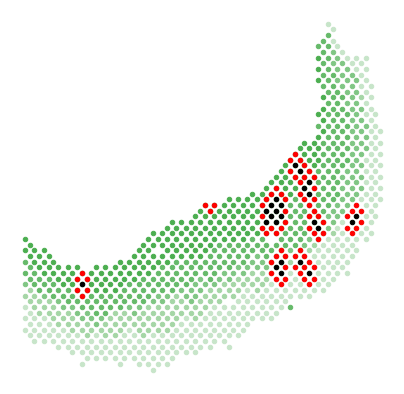

In [284]:
plq_coords = spot_df[spot_df['plaque']==1]['array_row'].values, spot_df[spot_df['plaque']==1]['array_col'].values
nplq_coords = spot_df[spot_df['plaque']==0]['array_row'].values, spot_df[spot_df['plaque']==0]['array_col'].values
adj_coords =spot_df[spot_df['adj']==1]['array_row'].values, spot_df[spot_df['adj']==1]['array_col'].values

fig,ax = plt.subplots(figsize=(7,7))
for x in range(len(sort_clust[:5])): 
    curr_ = spot_df.iloc[np.where(spot_df['cluster'] == sort_clust[x])]
    plt.scatter(curr_['array_row'].values,curr_['array_col'].values, s=20, color = sort_col[x], alpha=1)

    plt.scatter(curr_['array_row'][curr_['adj']==1], curr_['array_col'][curr_['adj']==1], c = 'r', s=20)
    plt.scatter(curr_['array_row'][curr_['plaque']==1],curr_['array_col'][curr_['plaque']==1], c = 'k', s=20)


#remove all borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.savefig(s_fig + 'cluster-adj-plq.svg', transparent=True)
plt.show()
